In [59]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os
import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob
import sys
sys.path.append("/mnt/Science_revision/")
#Hashsolo imported from: https://github.com/theislab/scanpy/blob/master/scanpy/external/pp/_hashsolo.py
from hashsolo import hashsolo

os.getcwd()
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='Blues')
sc.logging.print_version_and_date()
sc.logging.print_header()

Running Scanpy 1.6.0, on 2022-03-07 09:24.
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.8 louvain==0.7.0


### Reading input data

In [60]:
meta = pd.read_csv('/mnt/Science_revision/meta_czi-uk.csv')

In [61]:
meta.head(1)

Unnamed: 0                    Hashtag+combined_ID  Sample ID (internal)  \
0           0  HTO_C0251_CZI-IA9924320+CZI-IA9924368                    33   

     Sample_ID Site Donor ID    Hashtag Fresh/frozen Cell type Sorting  ...  \
0  582C-SPL-33   UK     582C  HTO_C0251        Fresh       MNC     No   ...   

  GEX chem        GEX lib ADT lib         TCR lib         BCR lib  \
0     5'v2  CZI-IA9924320     NaN  CZI-IA10586214  CZI-IA10586223   

         HTO lib Organ Protein panel symbol                  combined_ID  
0  CZI-IA9924368   SPL          None      +  CZI-IA9924320+CZI-IA9924368  

[1 rows x 21 columns]

In [62]:
samples = meta['combined_ID'].unique()

In [63]:
len(samples)

20

#### visualize combined library ID and sample ID

In [64]:
for sample in samples:
    print(sample)
    sample_pool = list(meta[meta['combined_ID'] == sample]['Sample_ID'])
    print(sample_pool)
    

CZI-IA9924320+CZI-IA9924368
['582C-SPL-33', '582C-MLN-34']
CZI-IA9924321+CZI-IA9924369
['582C-TLN-35', '582C-JEJEPI-36', '582C-JEJLP-37']
CZI-IA10244332+CZI-IA10244434
['621B-SPL-86', '621B-MLN-87', '621B-TLN-88']
CZI-IA10244331+CZI-IA10244433
['621B-BLD-89', '621B-BMA-90']
CZI-IA10244335+CZI-IA10244437
['621B-JEJEPI-91', '621B-JEJLP-92', '621B-JEJEPI-99', '621B-JEJLP-100']
CZI-IA10466281+CZI-IA10466377
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
CZI-IA10466282+CZI-IA10466378
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
CZI-IA10466283+CZI-IA10466379
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
CZI-IA10466284+CZI-IA10466380
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
CZI-IA10466285+CZI-IA10466381
['637C-JEJLP-108', '637C-LNG-111']
CZI-IA10466286+CZI-IA10466382
['637C-JEJEPI-109']


In [65]:
## This metadata contains the 6 first donors from the CZI-UK cohort (note that donors 583B and 591C were excluded downstream based on age range; stimulated samples were also excluded downstream)

In [66]:
samples

array(['CZI-IA9924320+CZI-IA9924368', 'CZI-IA9924321+CZI-IA9924369',
       'CZI-IA10244332+CZI-IA10244434', 'CZI-IA10244331+CZI-IA10244433',
       'CZI-IA10244335+CZI-IA10244437', 'CZI-IA10466281+CZI-IA10466377',
       'CZI-IA10466282+CZI-IA10466378', 'CZI-IA10466283+CZI-IA10466379',
       'CZI-IA10466284+CZI-IA10466380', 'CZI-IA10466285+CZI-IA10466381',
       'CZI-IA10466286+CZI-IA10466382', 'CZI-IA10471909+CZI-IA10472005',
       'CZI-IA10471910+CZI-IA10472006', 'CZI-IA10471911+CZI-IA10472007',
       'CZI-IA10471912+CZI-IA10472008', 'CZI-IA10471913+CZI-IA10472009',
       'CZI-IA10471914+CZI-IA10472010', 'CZI-IA10471915+CZI-IA10472011',
       'CZI-IA10471916+CZI-IA10472012', 'CZI-IA10471917+CZI-IA10472013'],
      dtype=object)

#### hashsolo after GEX-based QC (min+genes=600, min_counts=1000) in a loop

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA9924320+CZI-IA9924368-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1686 cells that have less than 600 genes expressed
filtered out 8 cells that have less than 1000 counts


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical


Number of cells after min_genes and min_counts filter: 7877
CZI-IA9924320+CZI-IA9924368
['582C-SPL-33', '582C-MLN-34']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local

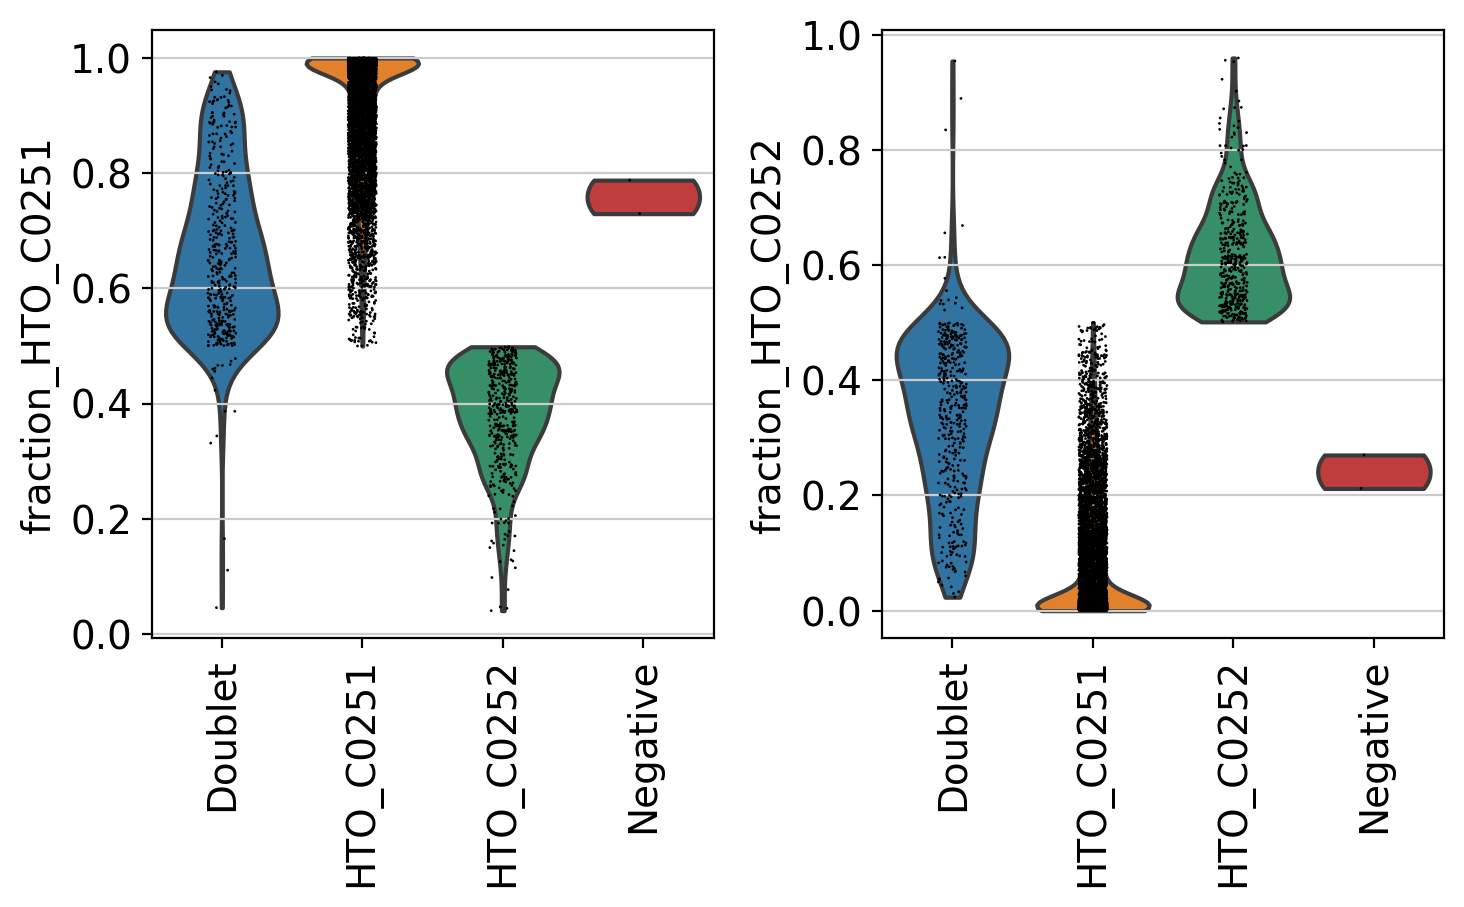

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA9924321+CZI-IA9924369-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1948 cells that have less than 600 genes expressed
filtered out 7 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 5572
CZI-IA9924321+CZI-IA9924369
['582C-TLN-35', '582C-JEJEPI-36', '582C-JEJLP-37']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

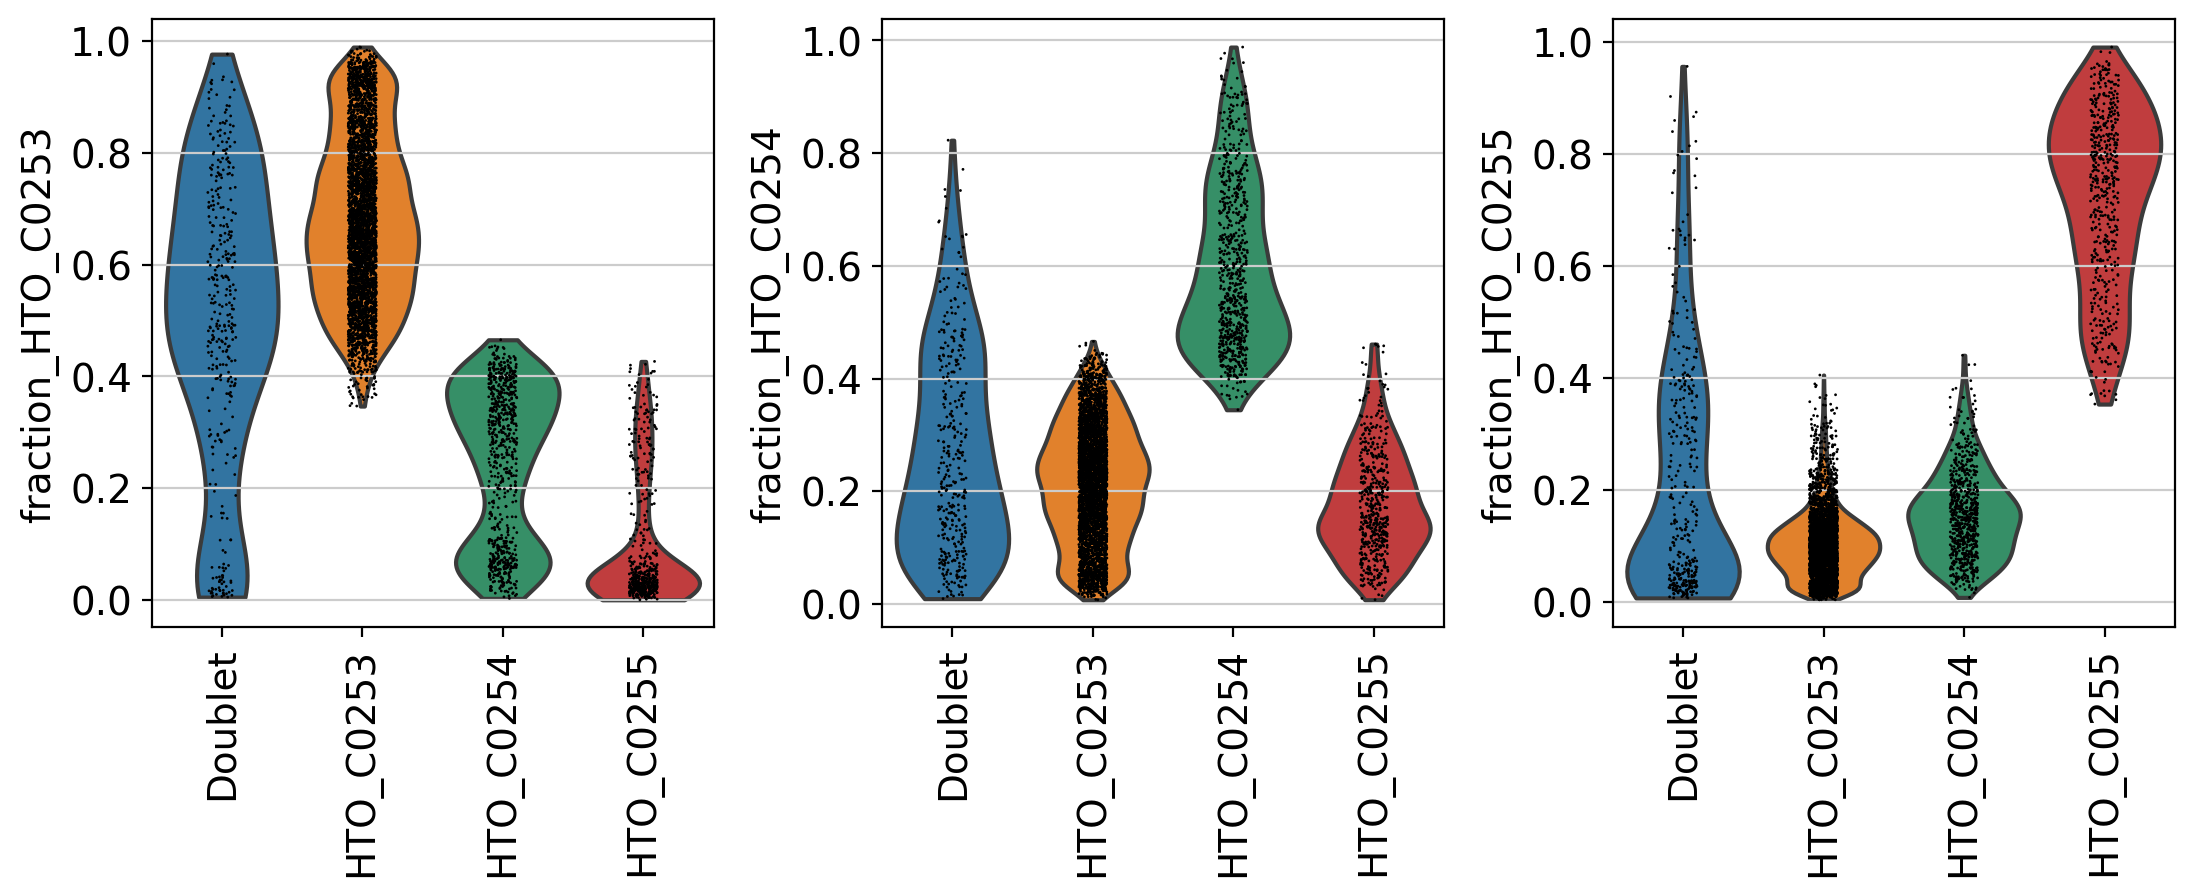

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10244332+CZI-IA10244434-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1241 cells that have less than 600 genes expressed
filtered out 10 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 11378
CZI-IA10244332+CZI-IA10244434
['621B-SPL-86', '621B-MLN-87', '621B-TLN-88']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

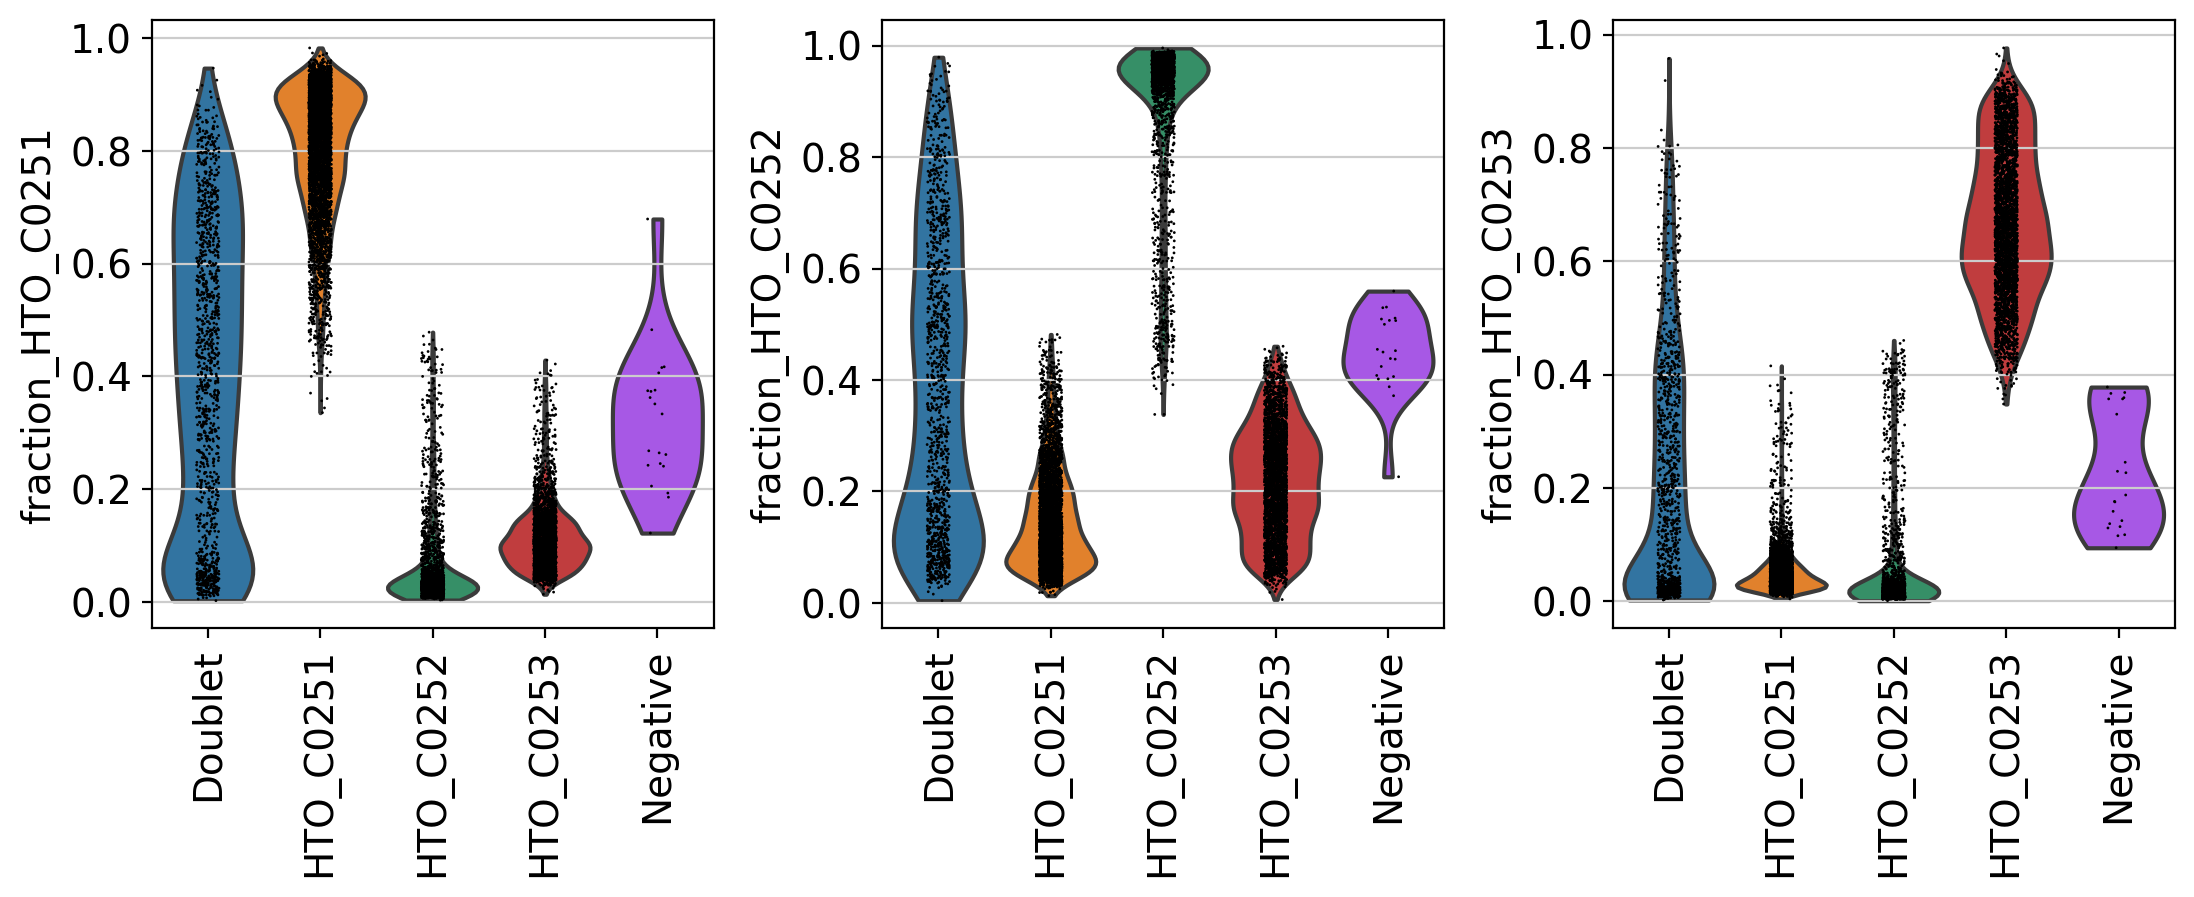

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10244331+CZI-IA10244433-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 5742 cells that have less than 600 genes expressed
filtered out 208 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 1519
CZI-IA10244331+CZI-IA10244433
['621B-BLD-89', '621B-BMA-90']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

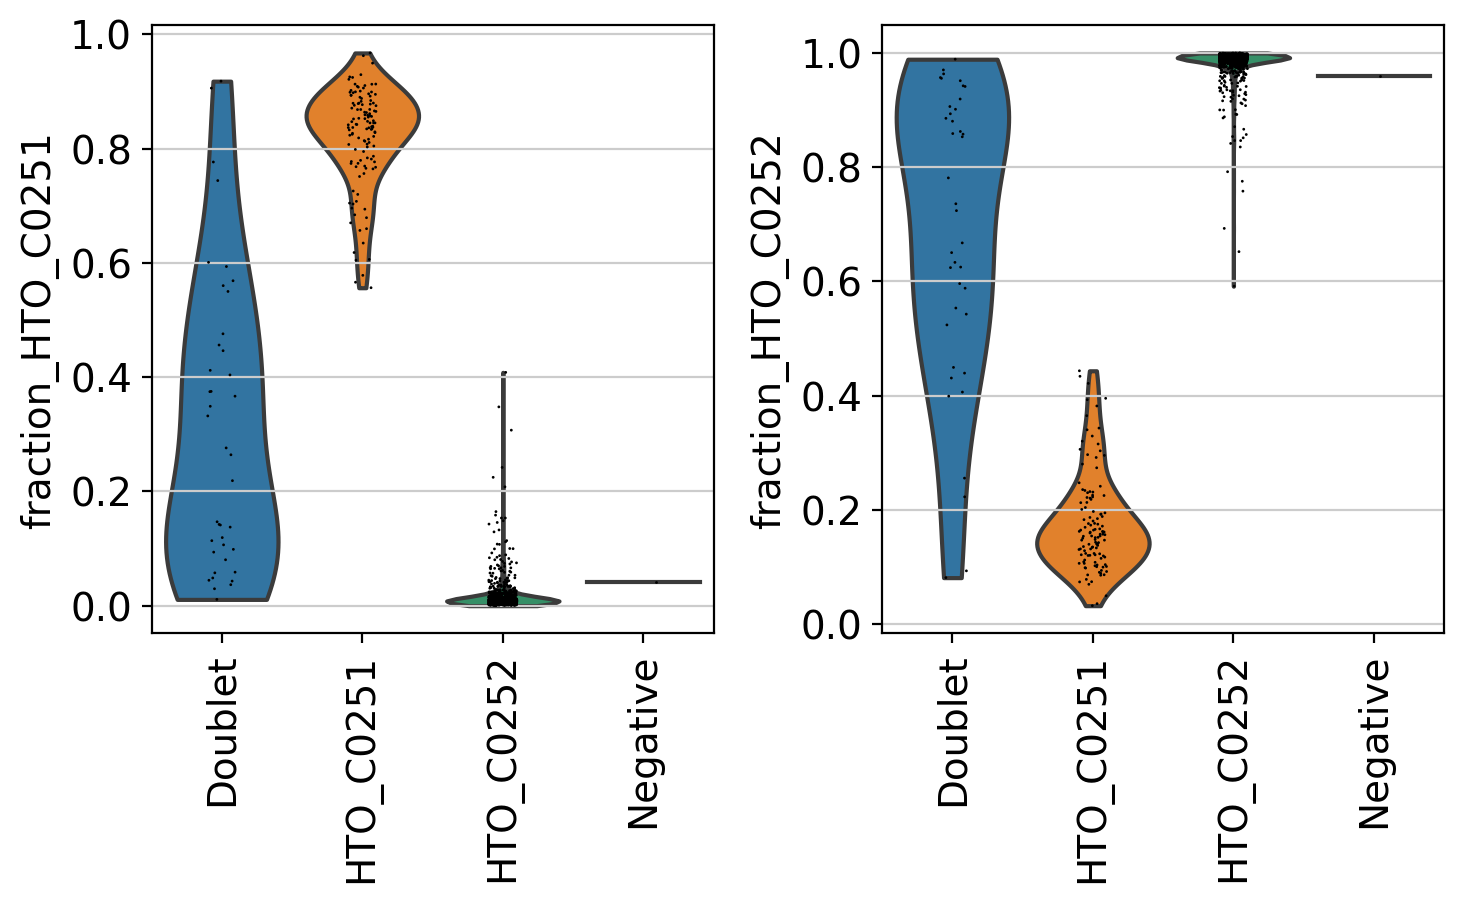

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10244335+CZI-IA10244437-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 30491 cells that have less than 600 genes expressed


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
... storing 'feature_types' as categorical


Number of cells after min_genes and min_counts filter: 0
CZI-IA10244335+CZI-IA10244437
['621B-JEJEPI-91', '621B-JEJLP-92', '621B-JEJEPI-99', '621B-JEJLP-100']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466281+CZI-IA10466377-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1774 cells that have less than 600 genes expressed
filtered out 27 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 7509
CZI-IA10466281+CZI-IA10466377
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

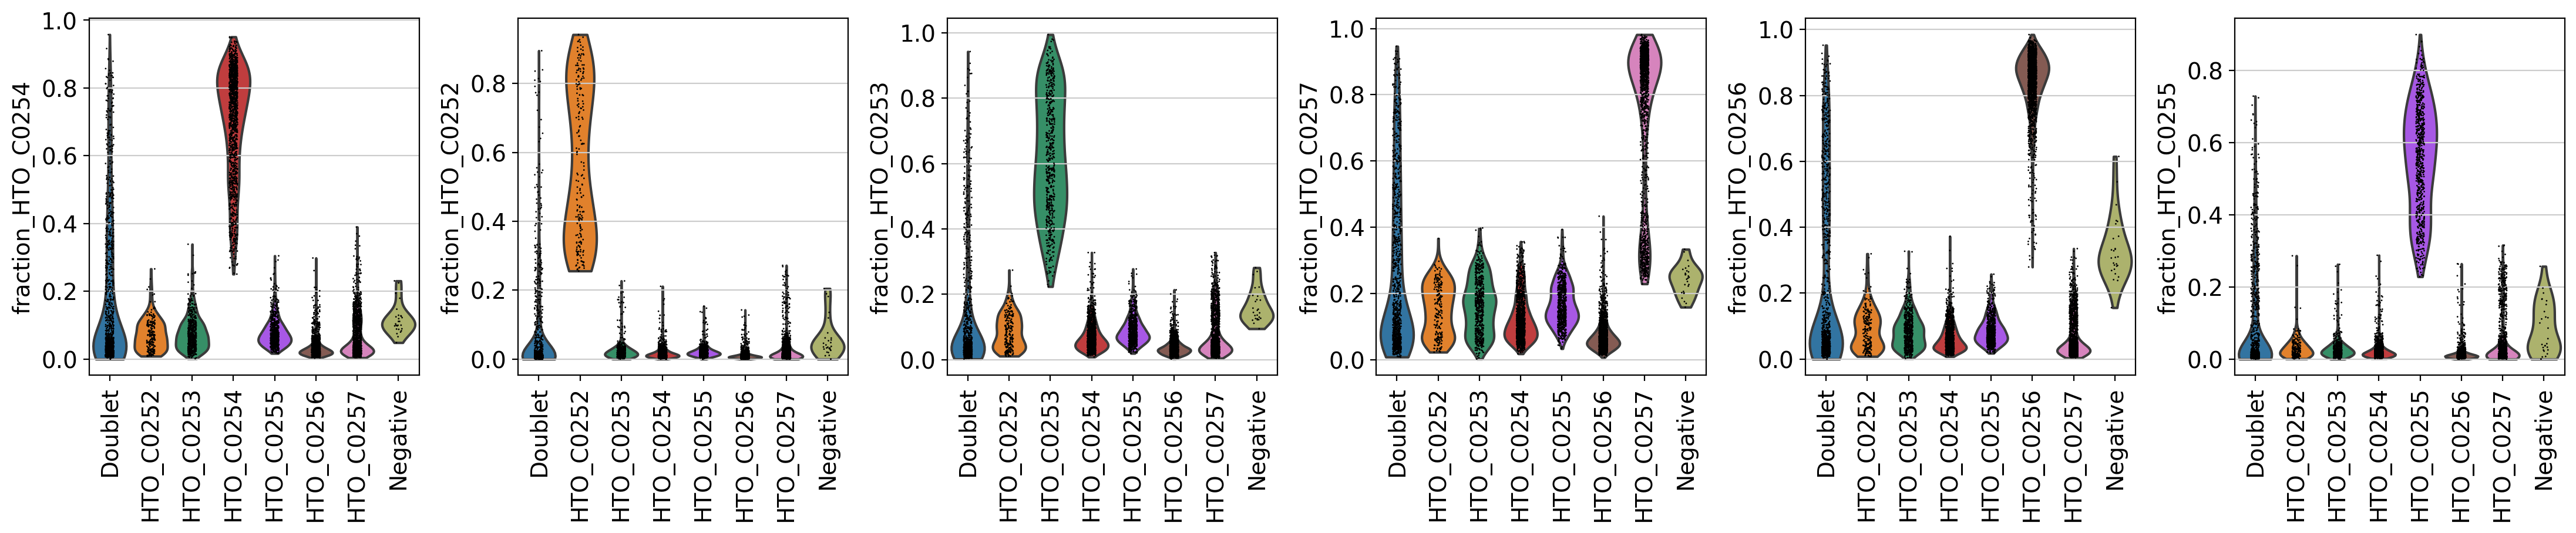

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466282+CZI-IA10466378-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1858 cells that have less than 600 genes expressed
filtered out 24 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 7407
CZI-IA10466282+CZI-IA10466378
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

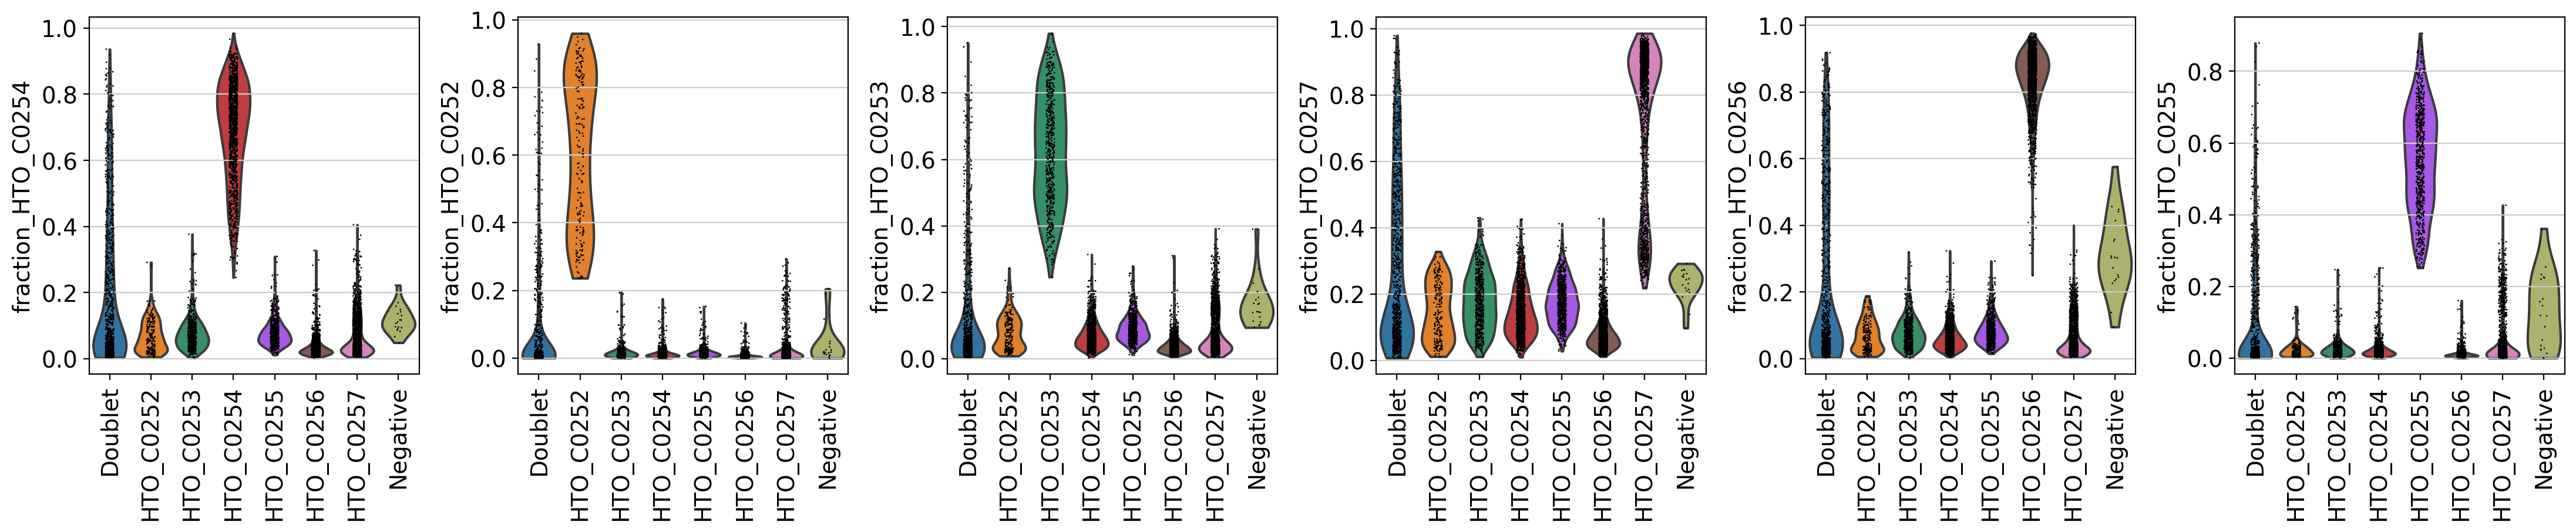

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466283+CZI-IA10466379-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1740 cells that have less than 600 genes expressed
filtered out 46 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 7442
CZI-IA10466283+CZI-IA10466379
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

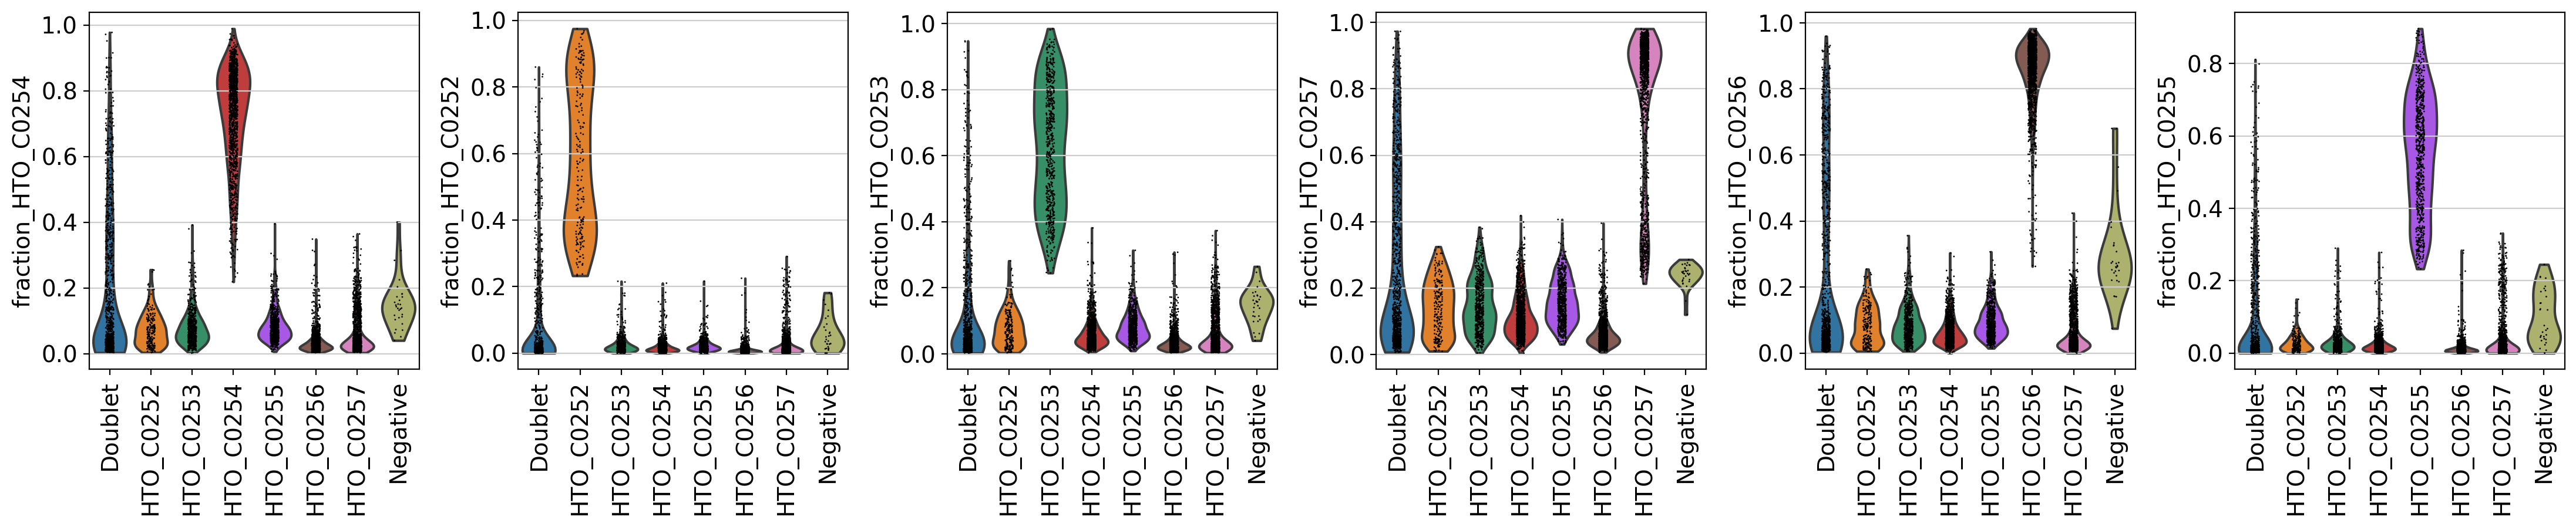

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466284+CZI-IA10466380-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 2178 cells that have less than 600 genes expressed
filtered out 29 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 8211
CZI-IA10466284+CZI-IA10466380
['637C-SPL-102', '637C-BLD-103', '637C-BMA-104', '637C-MLN-105', '637C-TLN-106', '637C-LIV-107']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

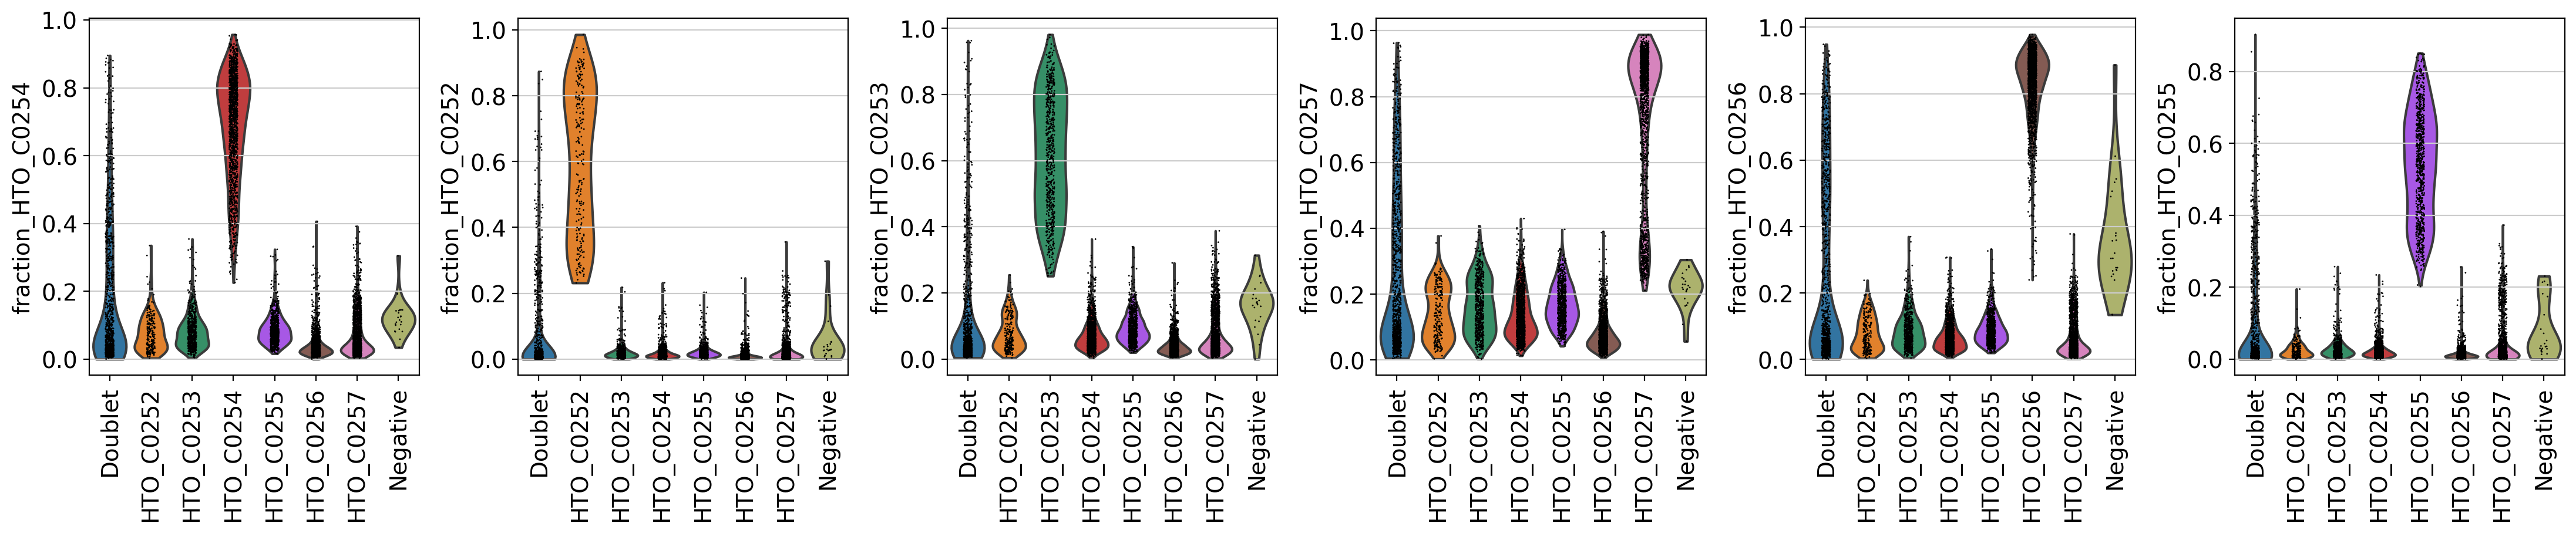

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466285+CZI-IA10466381-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 329 cells that have less than 600 genes expressed


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical


Number of cells after min_genes and min_counts filter: 152
CZI-IA10466285+CZI-IA10466381
['637C-JEJLP-108', '637C-LNG-111']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local

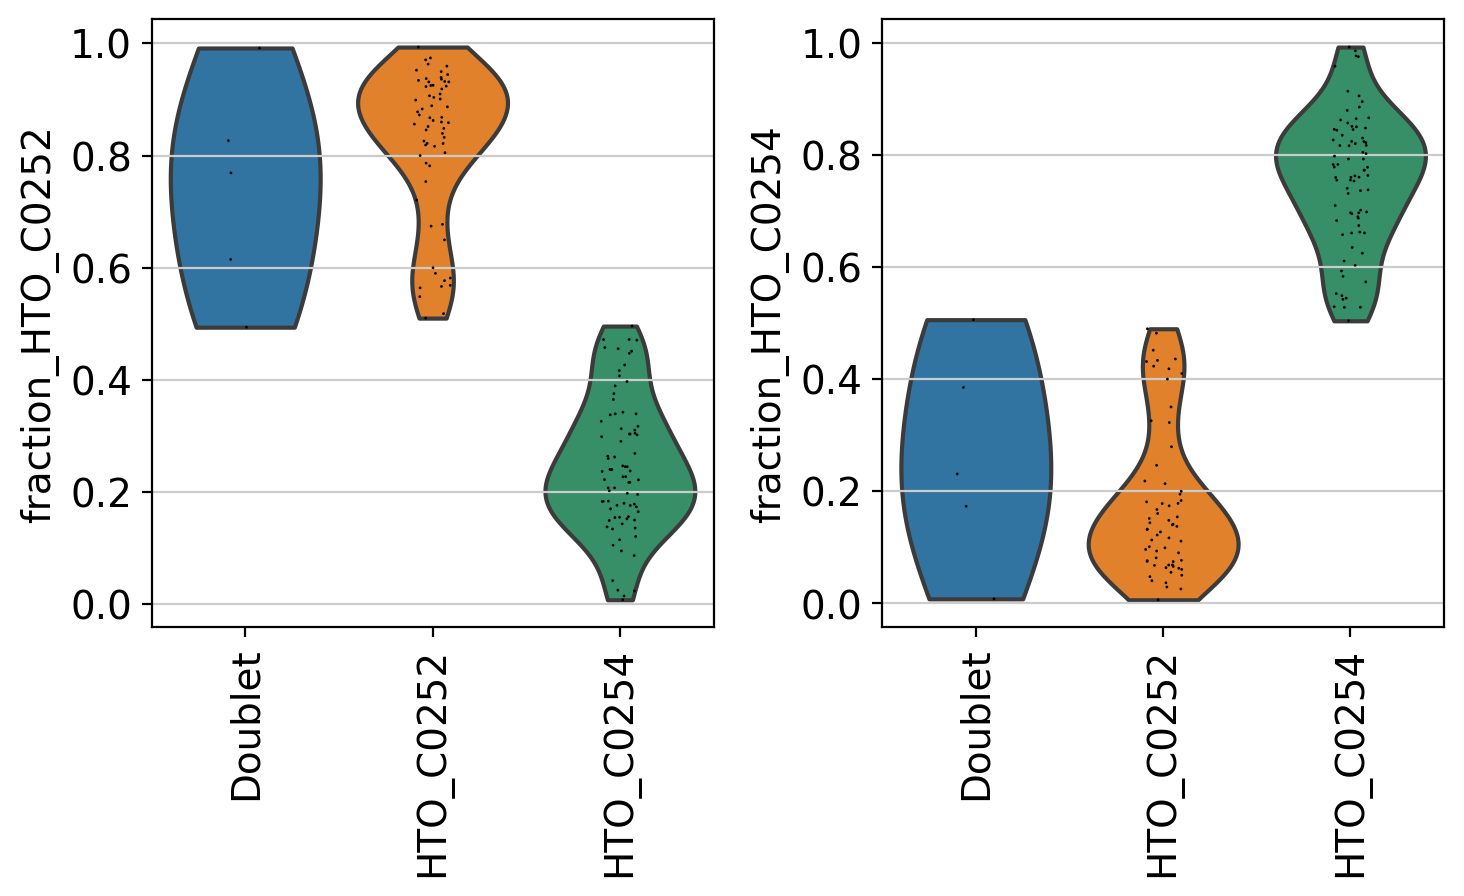

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10466286+CZI-IA10466382-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1675 cells that have less than 600 genes expressed
filtered out 40 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 8173
CZI-IA10466286+CZI-IA10466382
['637C-JEJEPI-109']
THIS SAMPLE IS NOT A POOL
... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471909+CZI-IA10472005-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1268 cells that have less than 600 genes expressed
filtered out 68 cells that have less than 1000 counts
Number of cell

... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

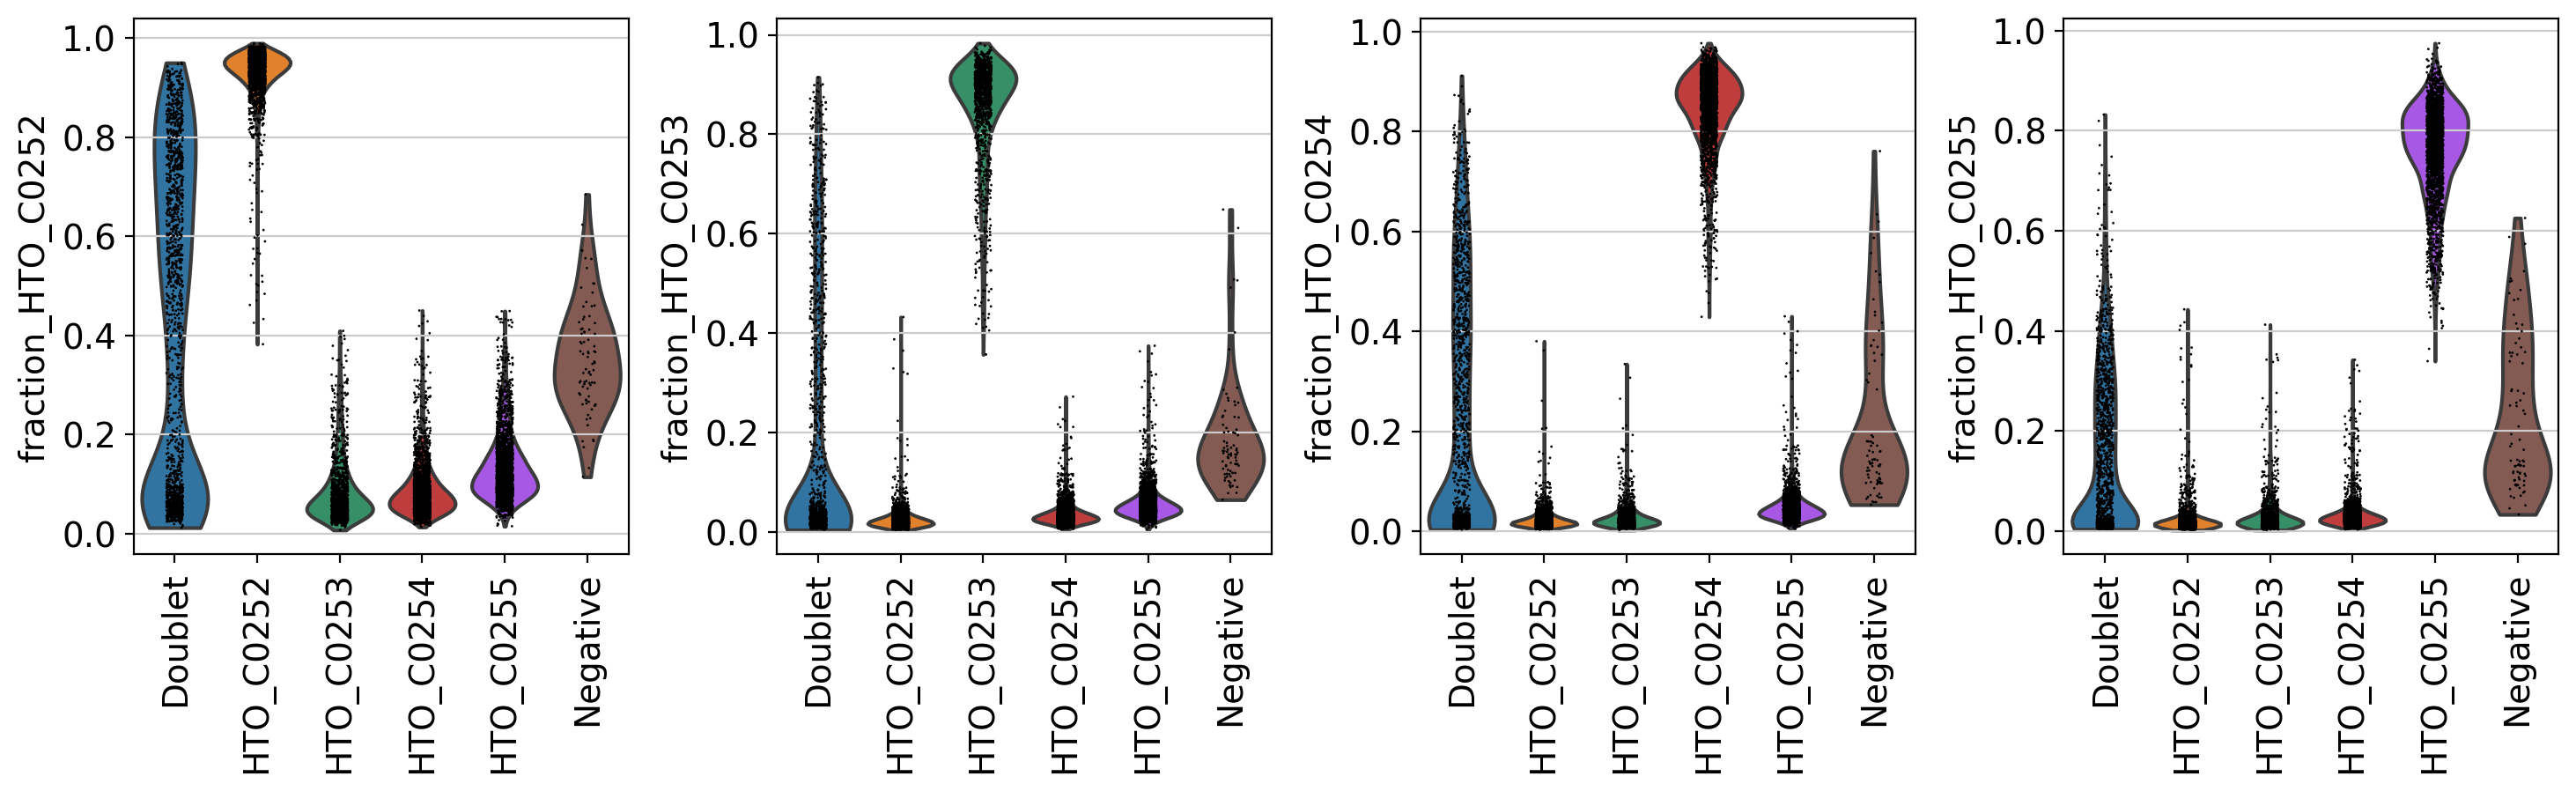

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471910+CZI-IA10472006-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1263 cells that have less than 600 genes expressed
filtered out 70 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 10788
CZI-IA10471910+CZI-IA10472006
['640C-SPL-120', '640C-BMA-121', '640C-TLN-122', '640C-MLN-123']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

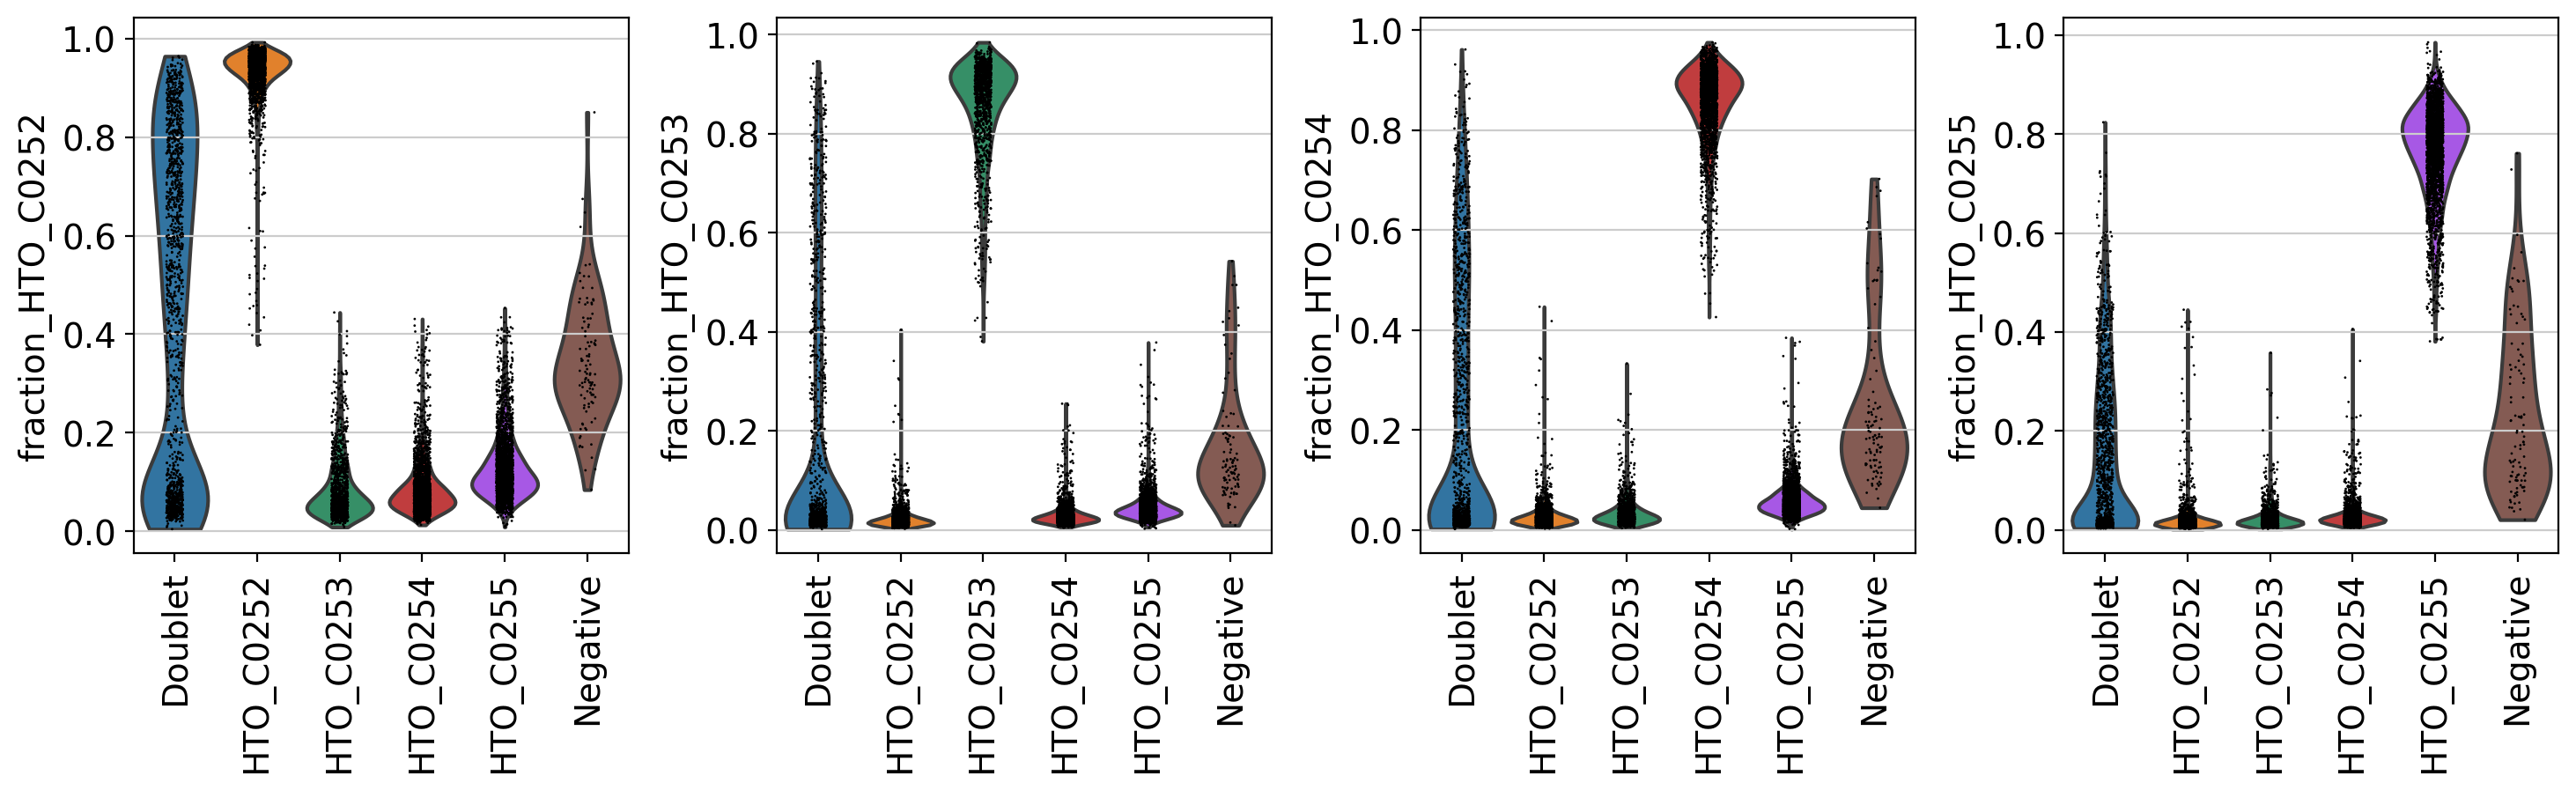

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471911+CZI-IA10472007-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 2069 cells that have less than 600 genes expressed
filtered out 94 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 8286
CZI-IA10471911+CZI-IA10472007
['640C-LIV-124', '640C-LNG-125', '640C-JEJEPI-126', '640C-JEJLP-127']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

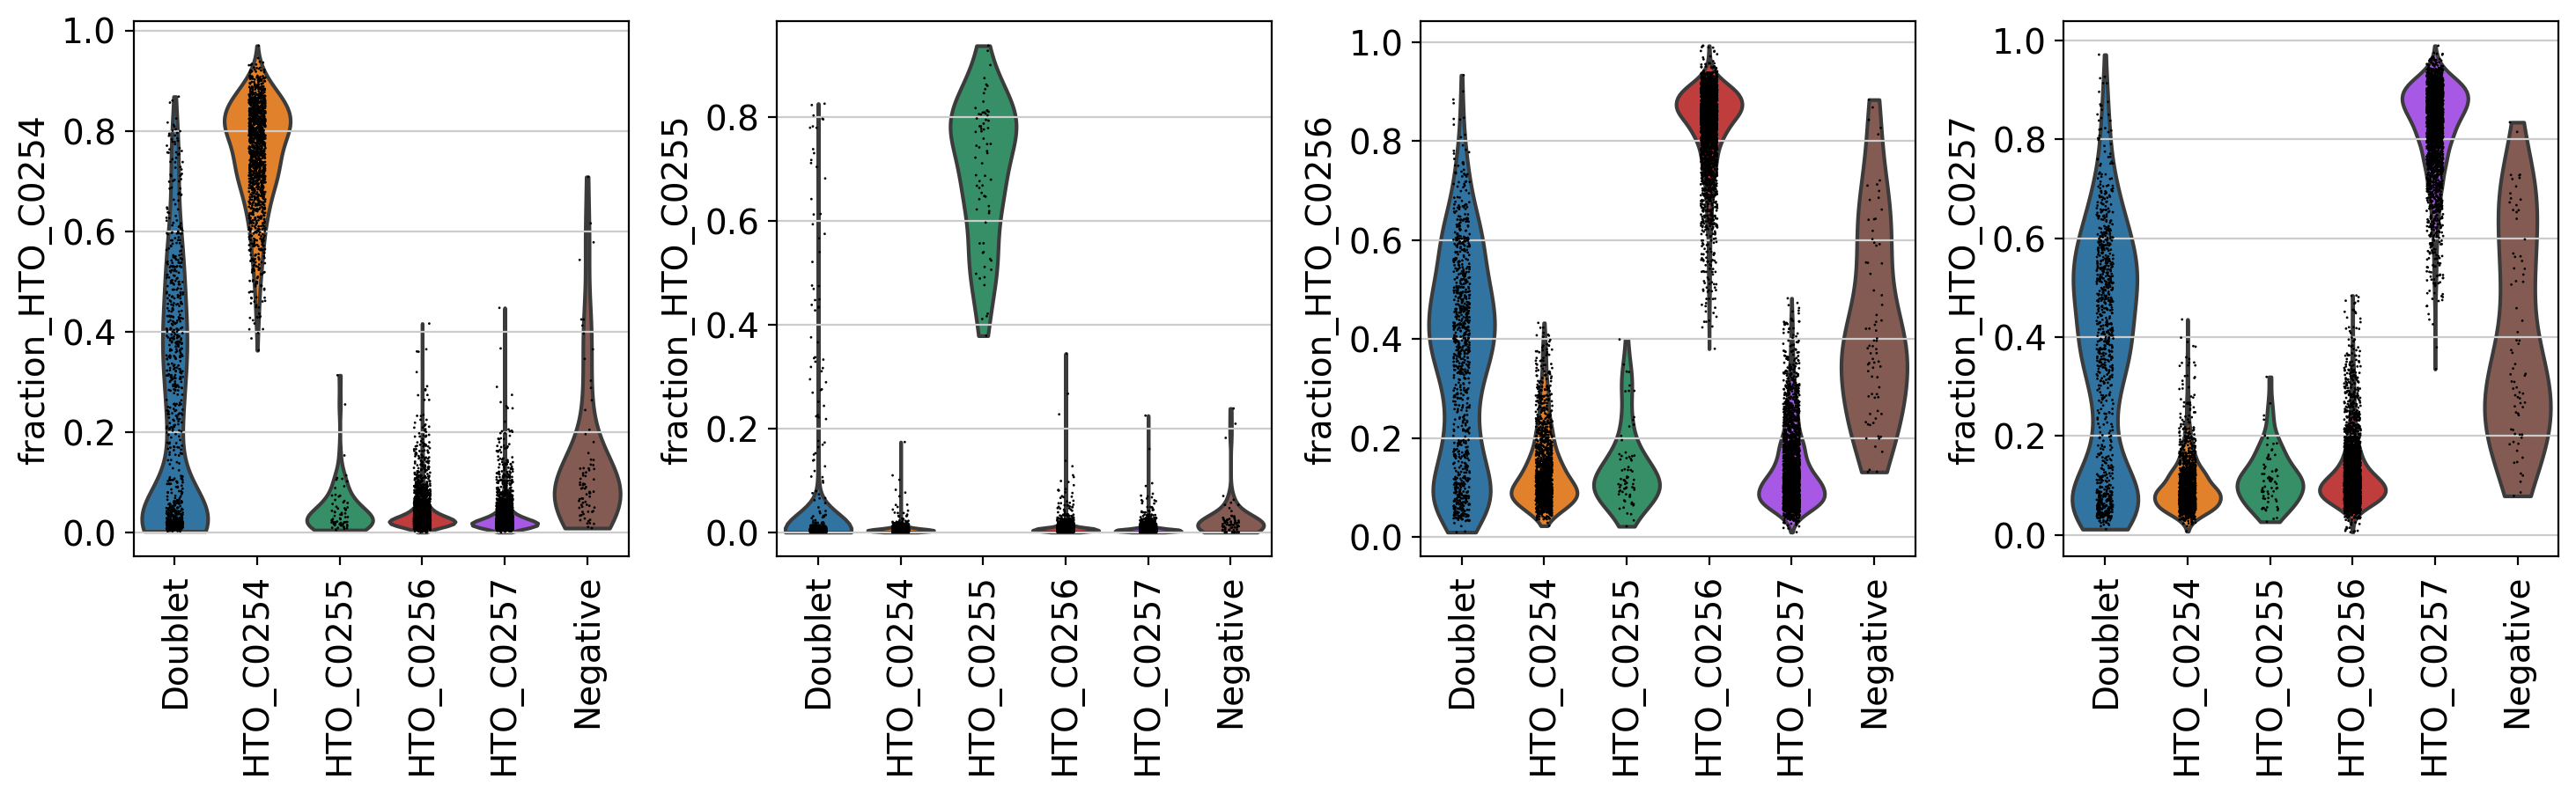

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471912+CZI-IA10472008-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 2357 cells that have less than 600 genes expressed
filtered out 86 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 8665
CZI-IA10471912+CZI-IA10472008
['640C-LIV-124', '640C-LNG-125', '640C-JEJEPI-126', '640C-JEJLP-127']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

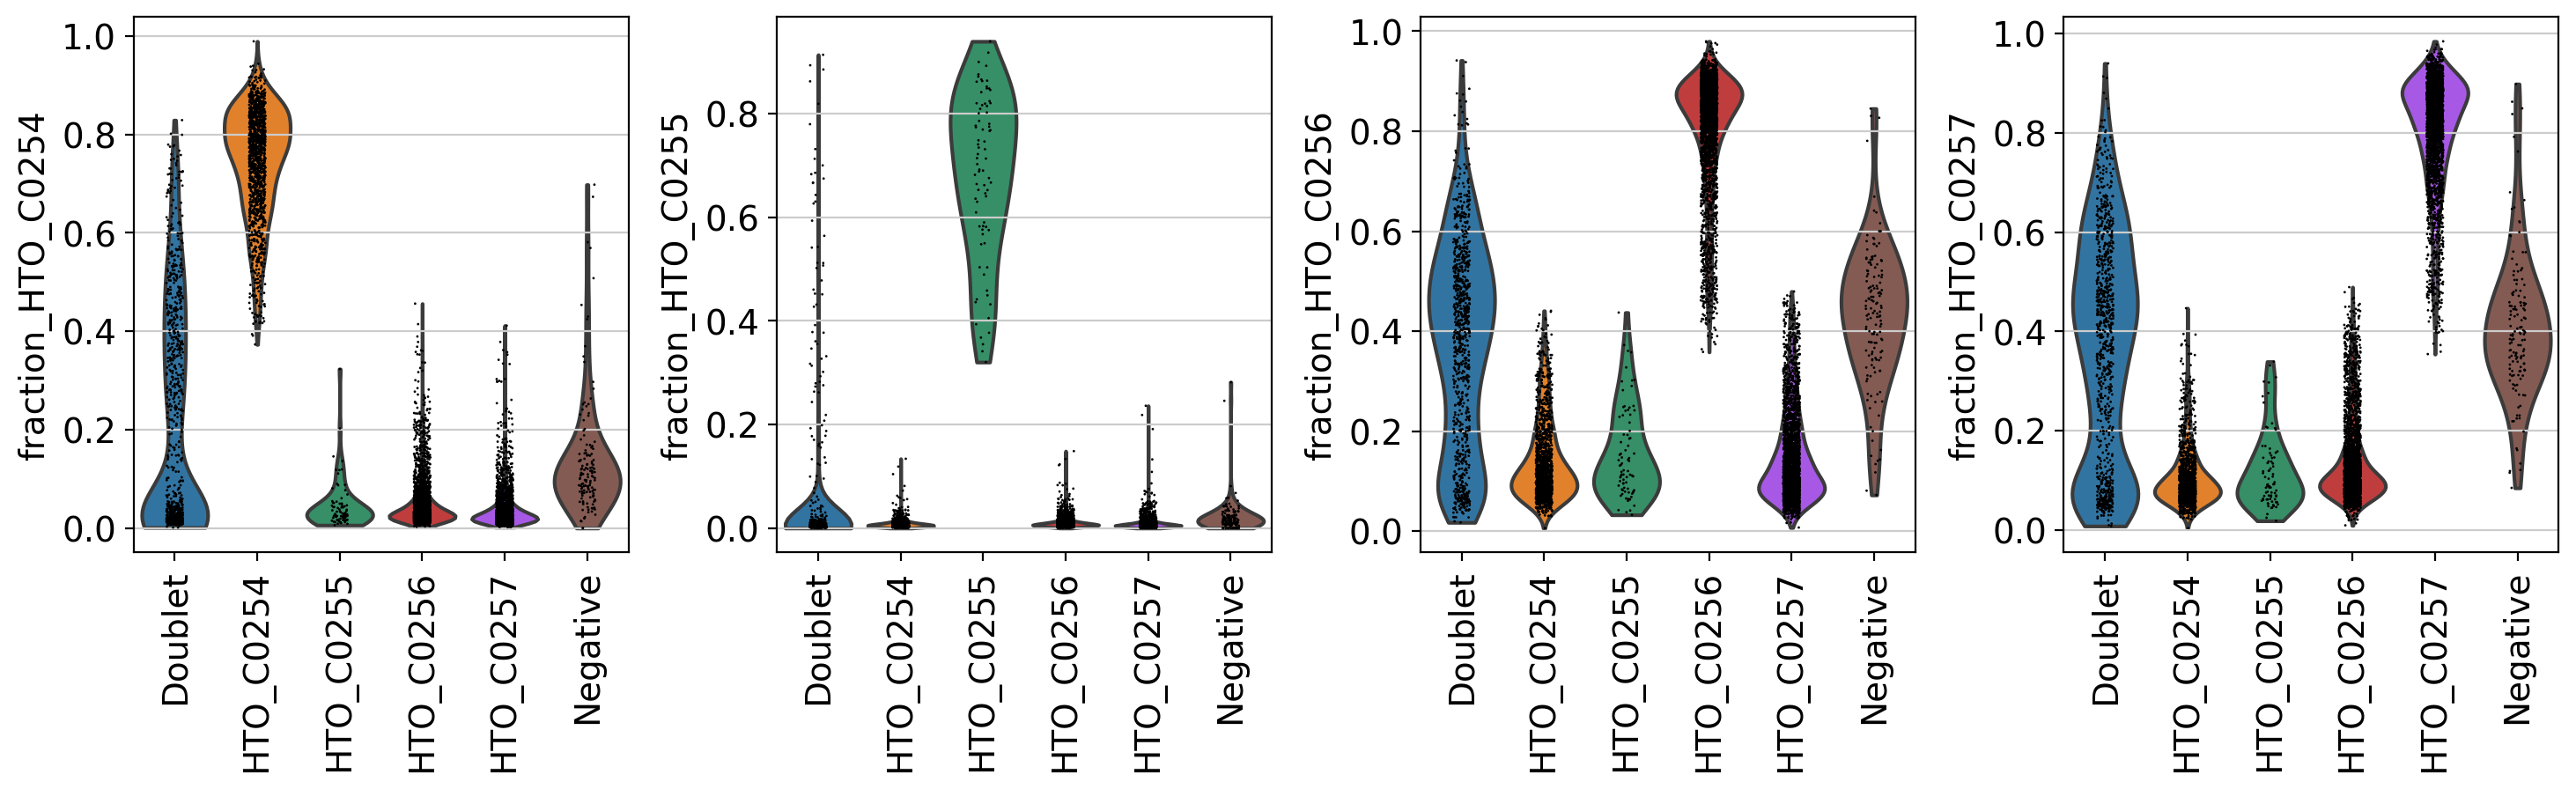

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471913+CZI-IA10472009-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 2114 cells that have less than 600 genes expressed
filtered out 85 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 7885
CZI-IA10471913+CZI-IA10472009
['640C-LIV-124', '640C-LNG-125', '640C-JEJEPI-126', '640C-JEJLP-127']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

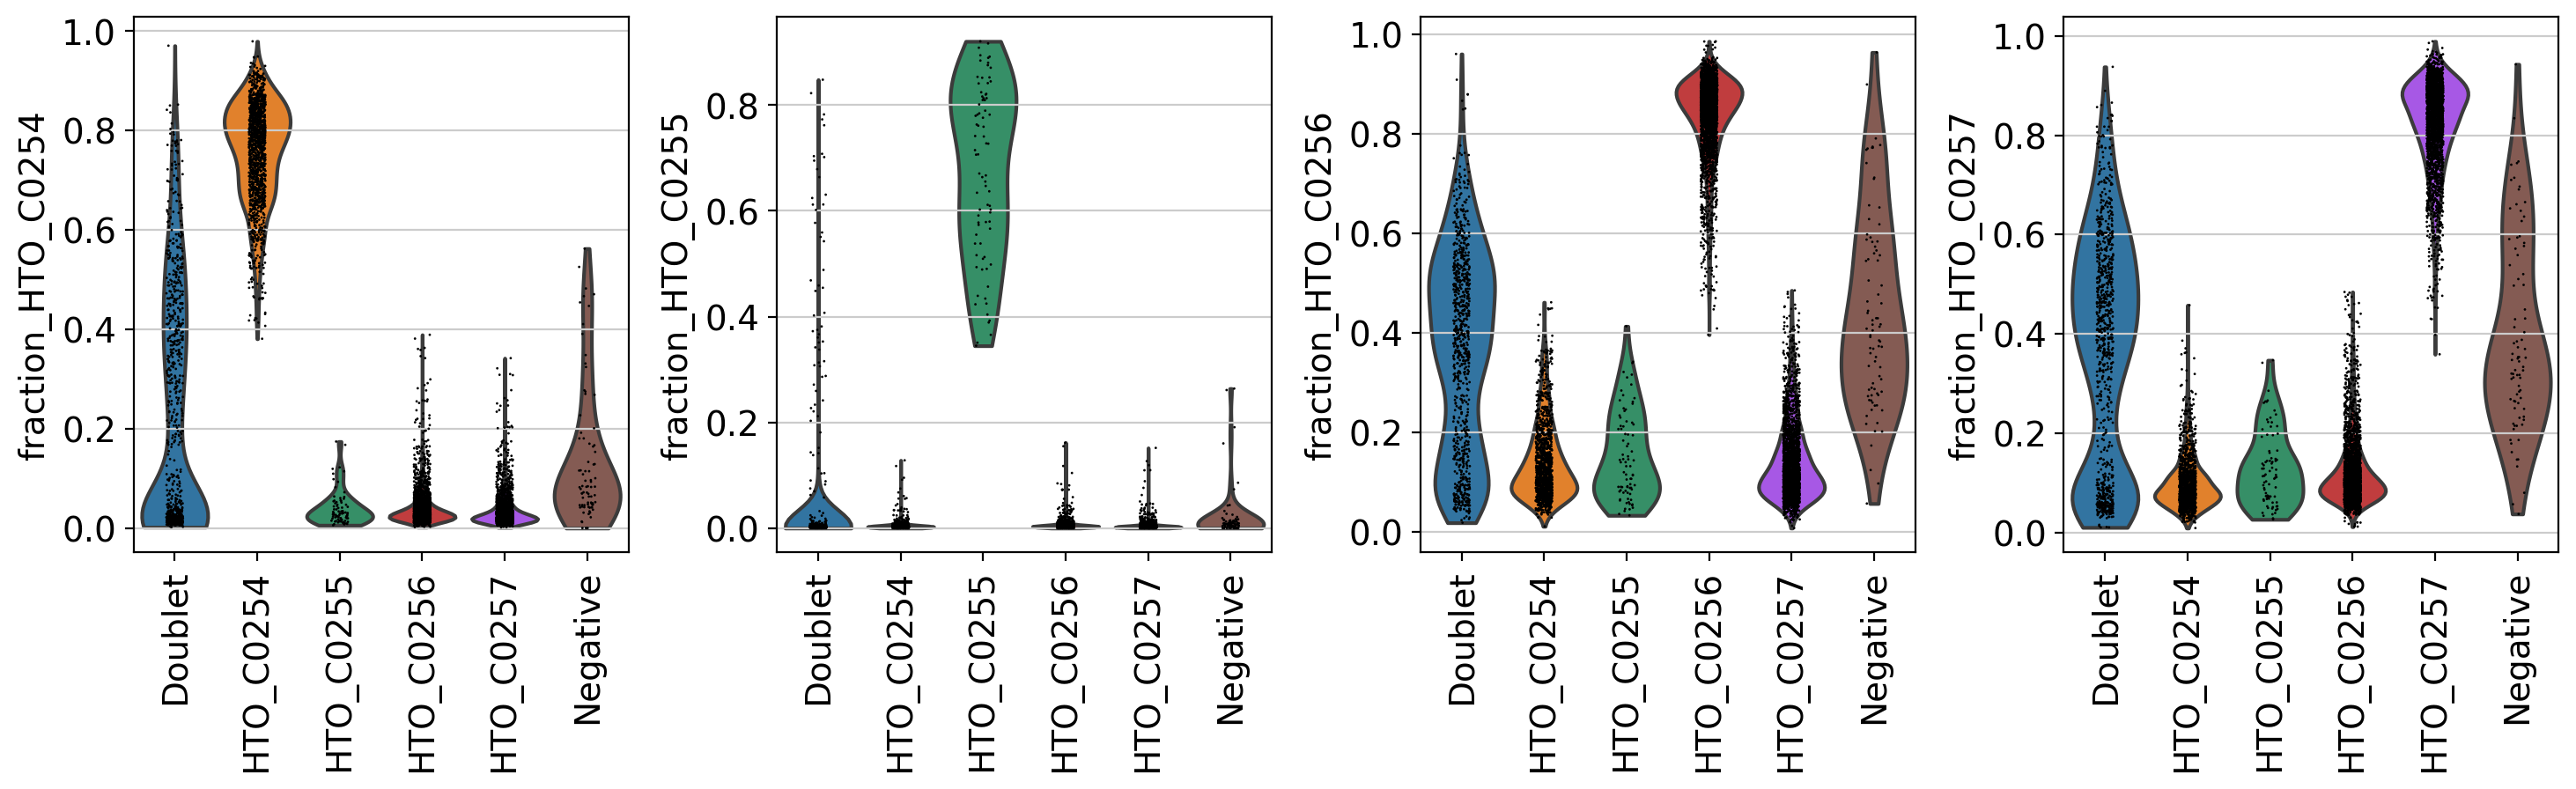

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471914+CZI-IA10472010-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1086 cells that have less than 600 genes expressed
filtered out 37 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 13949
CZI-IA10471914+CZI-IA10472010
['640C-SPL-129', '640C-BMA-130', '640C-TLN-131', '640C-MLN-132']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

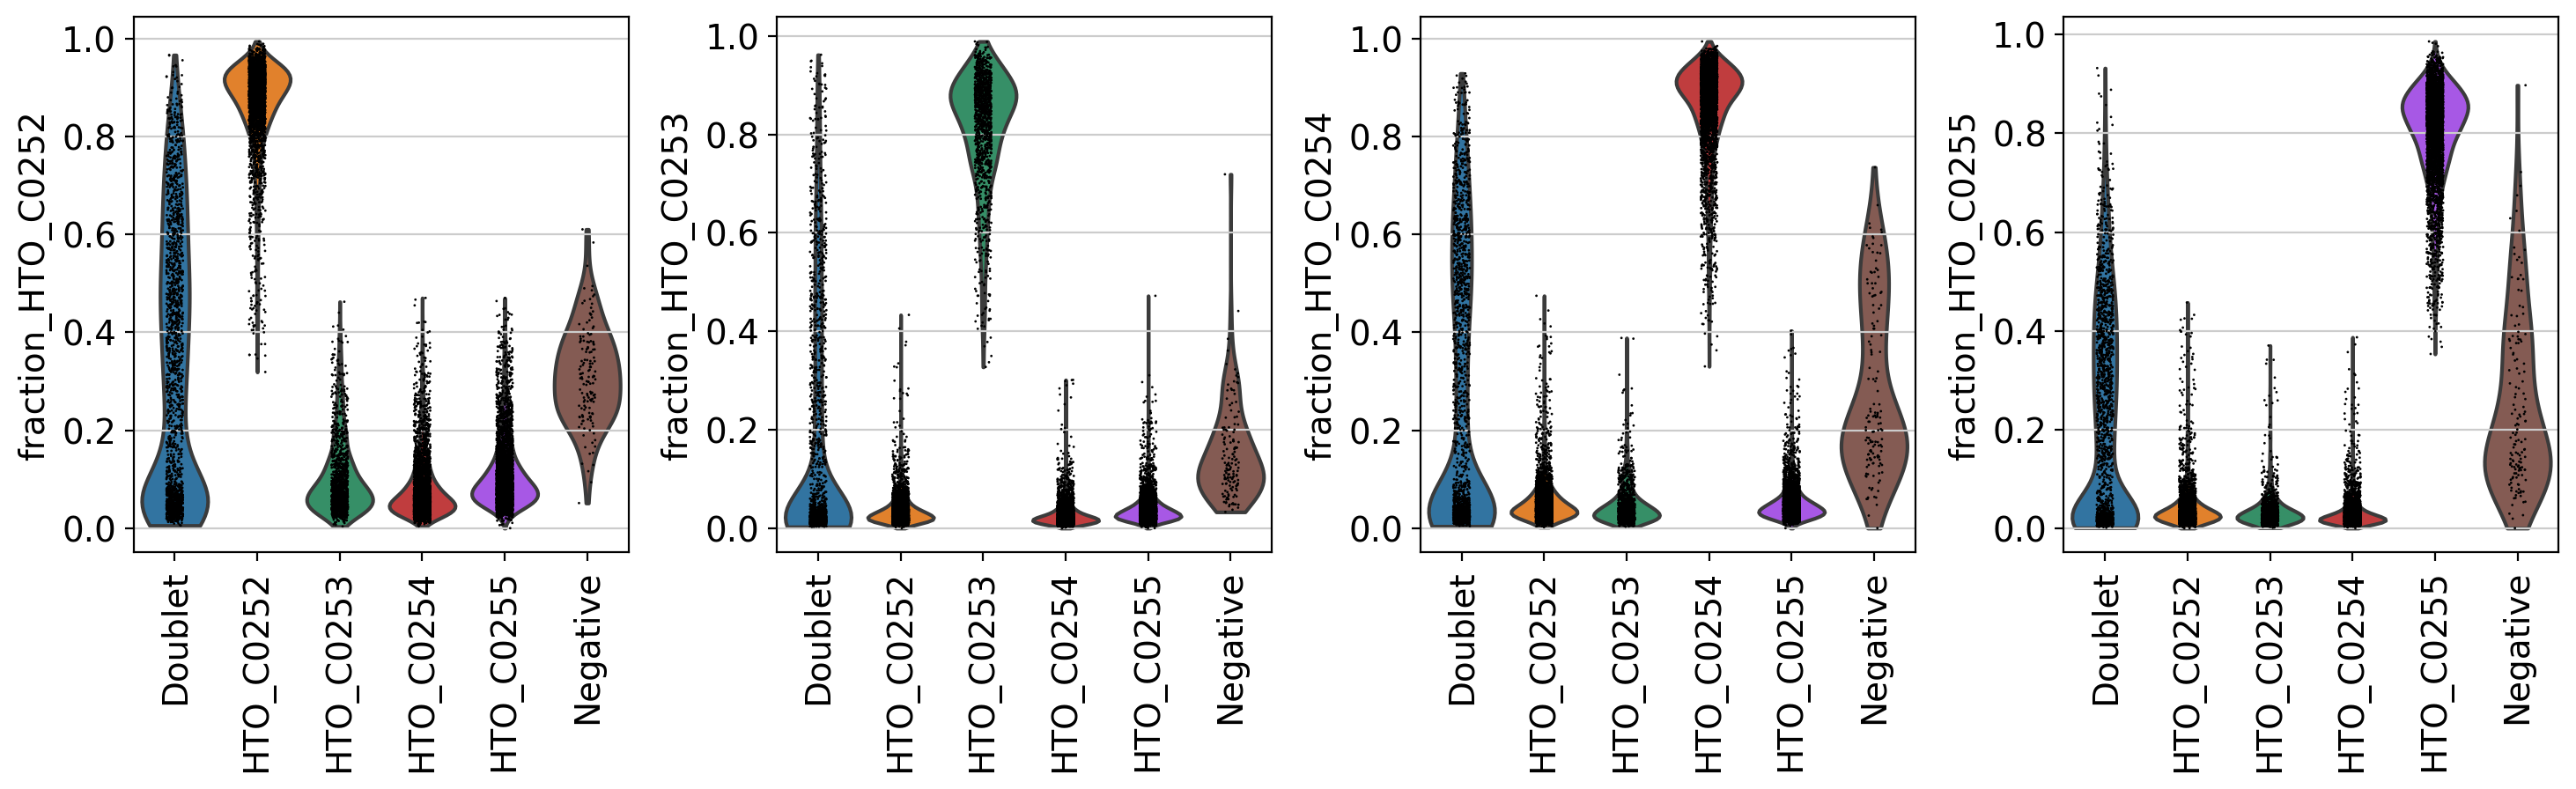

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471915+CZI-IA10472011-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 1169 cells that have less than 600 genes expressed
filtered out 36 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 14327
CZI-IA10471915+CZI-IA10472011
['640C-SPL-129', '640C-BMA-130', '640C-TLN-131', '640C-MLN-132']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

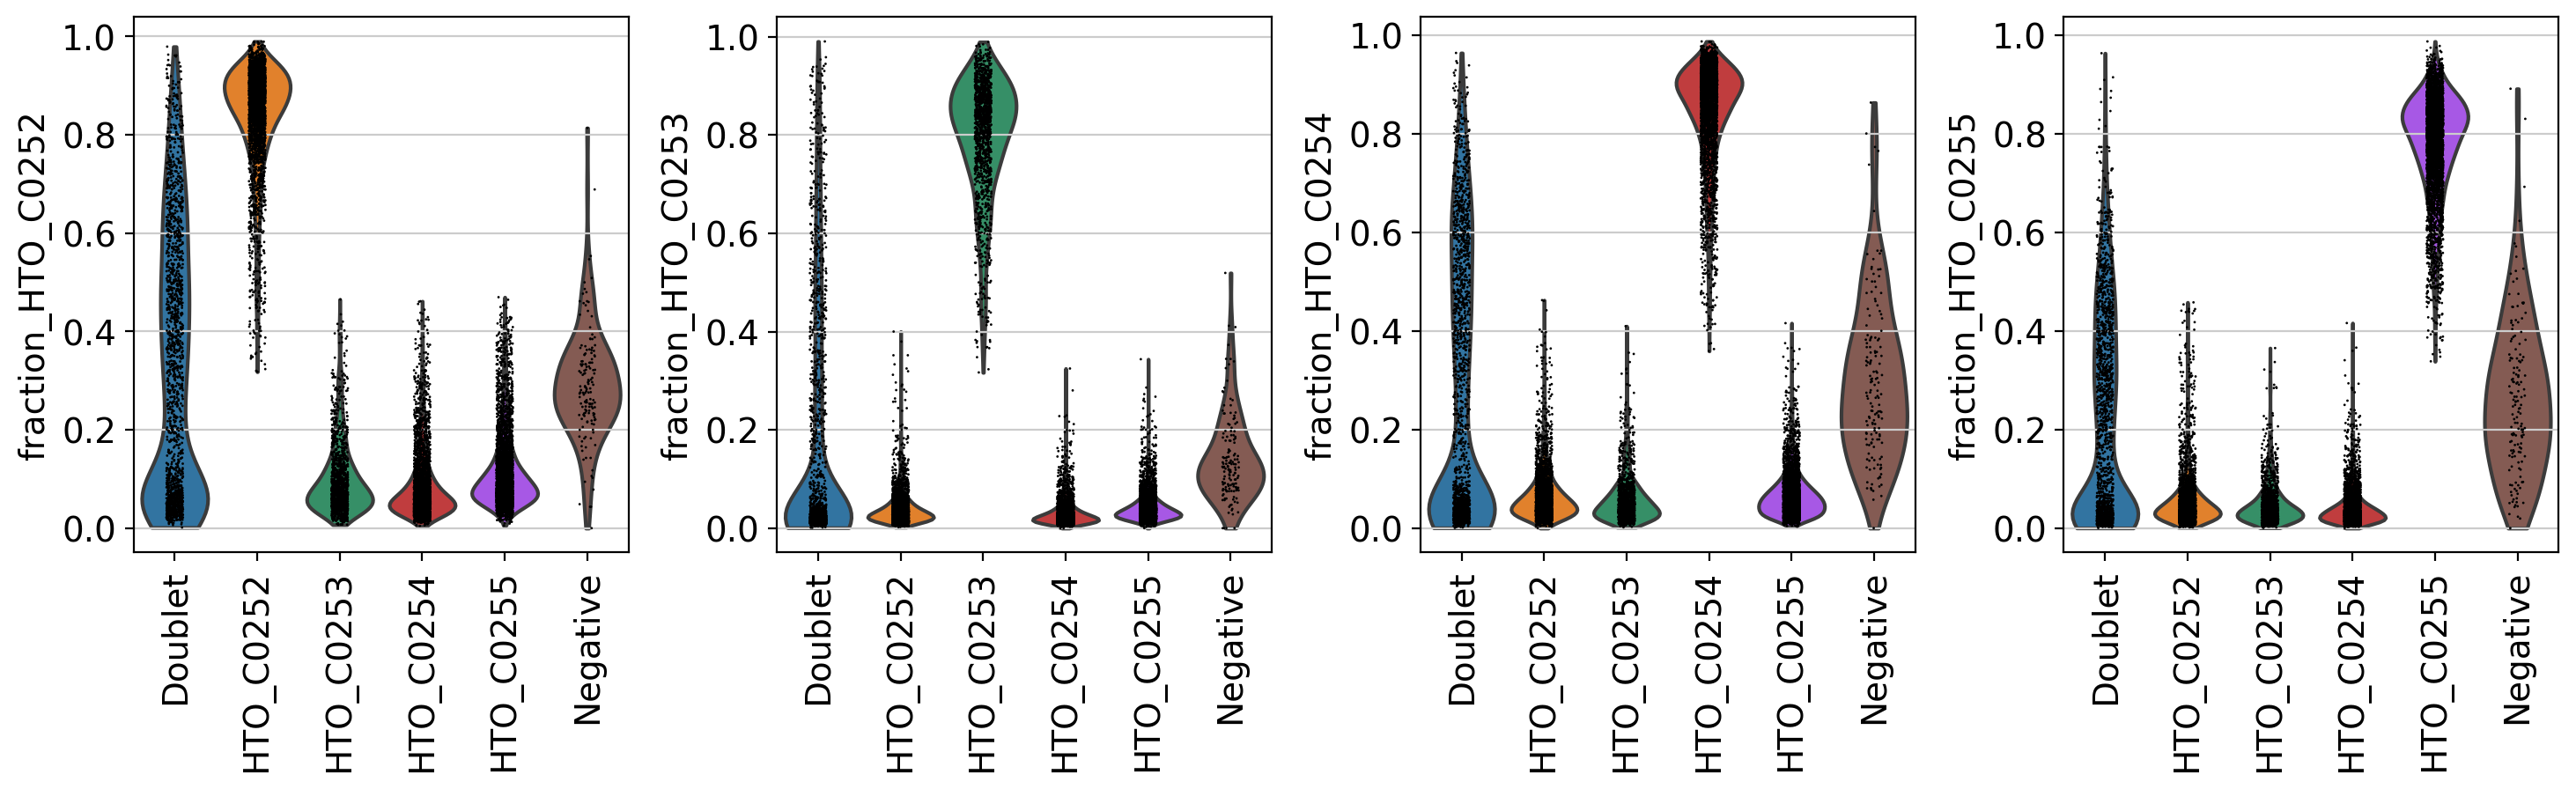

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471916+CZI-IA10472012-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 3784 cells that have less than 600 genes expressed
filtered out 52 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 9222
CZI-IA10471916+CZI-IA10472012
['640C-LIV-133', '640C-LNG-134', '640C-JEJEPI-135', '640C-JEJLP-136']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

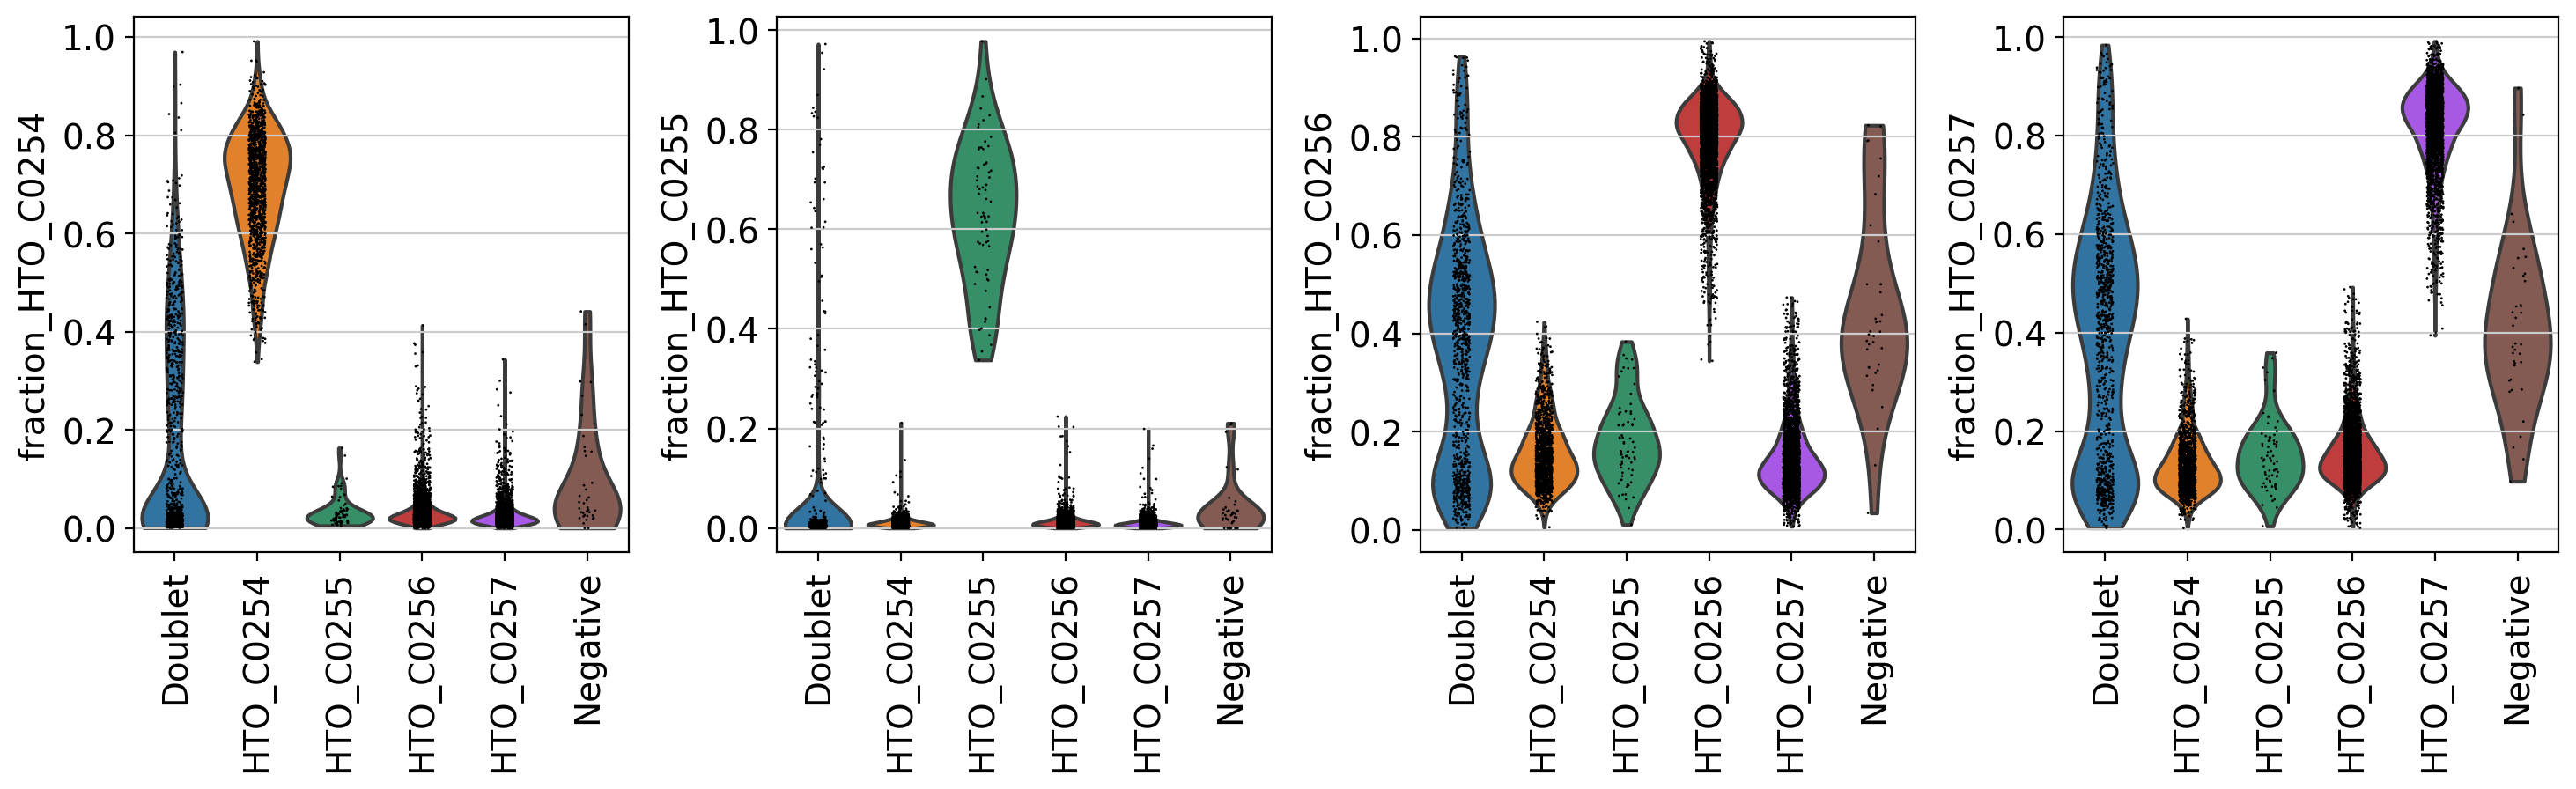

... reading from cache file cache/mnt-Science_revision-rawdata-CZIUK-rawdata-rawdata-CZI-IA10471917+CZI-IA10472013-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 3531 cells that have less than 600 genes expressed
filtered out 56 cells that have less than 1000 counts
Number of cells after min_genes and min_counts filter: 9201
CZI-IA10471917+CZI-IA10472013
['640C-LIV-133', '640C-LNG-134', '640C-JEJEPI-135', '640C-JEJLP-136']
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passi

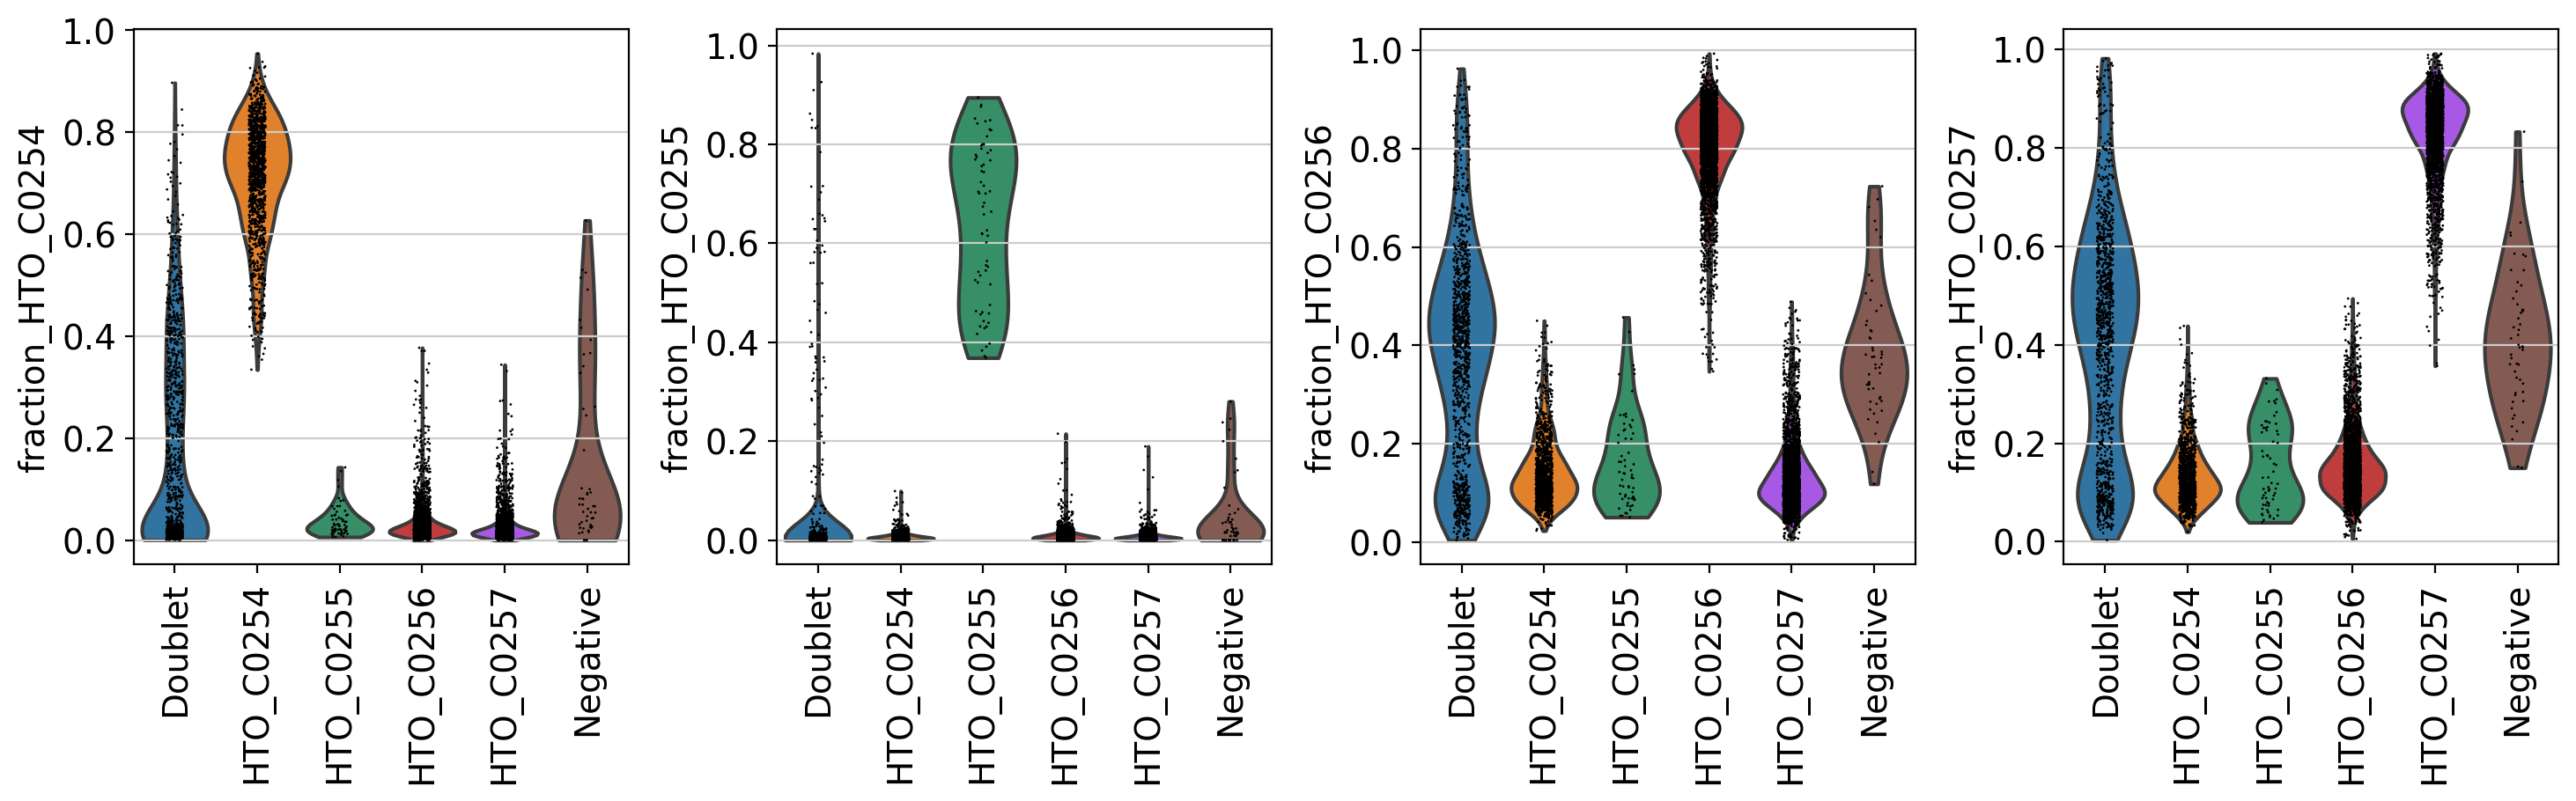

In [67]:
holder = []

hashtags = ['HTO_C0251',
 'HTO_C0252',
 'HTO_C0253',
 'HTO_C0254',
 'HTO_C0255',
 'HTO_C0256',
 'HTO_C0257']

for sample in samples:    
        holder.append(sc.read_10x_mtx('/mnt/Science_revision/rawdata/CZIUK/rawdata/rawdata/'+sample+'/filtered_feature_bc_matrix', cache=True, gex_only=False))
        holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
        holder[-1].obs['combined_ID'] = sample   
    ##add hashtag counts to adata.obs before adata.X normalization
        holder[-1].obs[hashtags] = holder[-1][:,['C0251', 'C0252', 'C0253', 'C0254', 'C0255', 'C0256', 'C0257']].X.toarray()
    ##calculate hto fractions
        sample_htos = list(meta[meta['combined_ID'] == sample]['Hashtag'])
        hto_var = ['C0251', 'C0252', 'C0253', 'C0254', 'C0255', 'C0256', 'C0257']
        holder[-1].obs['total_hto_counts'] = np.sum(holder[-1][:,hto_var].X, axis=1).A1
        for n in sample_htos:
            holder[-1].obs['fraction_'+n] = holder[-1].obs[n]/holder[-1].obs['total_hto_counts']
            
    ##remove antibody counts from adata.X 
        protein_flag = holder[-1].var['feature_types'] == 'Antibody Capture'
        holder[-1] = holder[-1][:, ~protein_flag].copy()
    
            
    #add fraction of mitochondrial genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
        mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
        holder[-1].obs['fraction_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
        
    #add the total counts per cell as observations-annotation to adata
        #holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
        
        sc.pp.normalize_per_cell(holder[-1], counts_per_cell_after=1e4)
        sc.pp.log1p(holder[-1])
    
        holder[-1].raw = holder[-1]
        
    ##QC filter    
        sc.pp.filter_cells(holder[-1], min_genes=600)
        sc.pp.filter_cells(holder[-1], min_counts=1000)
        print('Number of cells after min_genes and min_counts filter: {:d}'.format(holder[-1].n_obs))

        print(sample)
        sample_pool = list(meta[meta['combined_ID'] == sample]['Sample_ID'])
        print(sample_pool)
        holder[-1].obs.shape
    ##hashsolo
        if len(sample_htos)>1:
            hashsolo(holder[-1], cell_hashing_columns=sample_htos, number_of_noise_barcodes=len(sample_htos)-1)
            fract_hto = [col for col in holder[-1].obs if col.startswith('fraction_HTO')]
            try:
                sc.pl.violin(holder[-1],keys=fract_hto, groupby='Classification', rotation=90)
            except:
                continue
        else:
            print('THIS SAMPLE IS NOT A POOL')
        

#### concatenate all objects in the holder list under a single object

In [68]:
adata = holder[0].concatenate(holder[1:], join='outer', index_unique=None)

#### Exclude doublets and droplets without assigned hashtag i.e. "Negative", as determined by hashsolo

In [69]:
adata = adata[~adata.obs['Classification'].isin(['Doublet','Negative'])]

In [70]:
adata.obs['Classification'].unique()

array(['HTO_C0251', 'HTO_C0252', 'HTO_C0255', 'HTO_C0253', 'HTO_C0254',
       'HTO_C0256', 'HTO_C0257', nan], dtype=object)

#### Create a new column with a concatenation of the assigned hashtag and the combined library ID

In [71]:
adata.obs['hash+lib'] = adata.obs['Classification'].astype(str)+'_'+adata.obs['combined_ID'].astype(str)

Trying to set attribute `.obs` of view, copying.


In [72]:
adata.obs['hash+lib'].unique()

array(['HTO_C0251_CZI-IA9924320+CZI-IA9924368',
       'HTO_C0252_CZI-IA9924320+CZI-IA9924368',
       'HTO_C0255_CZI-IA9924321+CZI-IA9924369',
       'HTO_C0253_CZI-IA9924321+CZI-IA9924369',
       'HTO_C0254_CZI-IA9924321+CZI-IA9924369',
       'HTO_C0251_CZI-IA10244332+CZI-IA10244434',
       'HTO_C0253_CZI-IA10244332+CZI-IA10244434',
       'HTO_C0252_CZI-IA10244332+CZI-IA10244434',
       'HTO_C0252_CZI-IA10244331+CZI-IA10244433',
       'HTO_C0251_CZI-IA10244331+CZI-IA10244433',
       'HTO_C0254_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0256_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0253_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0257_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0255_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0252_CZI-IA10466281+CZI-IA10466377',
       'HTO_C0254_CZI-IA10466282+CZI-IA10466378',
       'HTO_C0257_CZI-IA10466282+CZI-IA10466378',
       'HTO_C0256_CZI-IA10466282+CZI-IA10466378',
       'HTO_C0253_CZI-IA10466282+CZI-IA10466378',
       'HT

In [73]:
##accounting for the nan hashtag values, i.e. libraries with only one sample per library but hashtag in the metadata

In [74]:
meta[meta['GEX lib'] == 'CZI-IA10034923']

Empty DataFrame
Columns: [Unnamed: 0, Hashtag+combined_ID, Sample ID (internal), Sample_ID, Site, Donor ID, Hashtag, Fresh/frozen, Cell type, Sorting, Stimulation, GEX chem, GEX lib, ADT lib, TCR lib, BCR lib, HTO lib, Organ, Protein panel, symbol, combined_ID]
Index: []

[0 rows x 21 columns]

In [75]:
meta[meta['GEX lib'] == 'CZI-IA10466286']

Unnamed: 0                Hashtag+combined_ID  Sample ID (internal)  \
39          70  nan_CZI-IA10466286+CZI-IA10466382                   109   

          Sample_ID Site Donor ID    Hashtag Fresh/frozen Cell type Sorting  \
39  637C-JEJEPI-109   UK     637C  HTO_C0253        Fresh       MNC     No    

    ... GEX chem         GEX lib         ADT lib         TCR lib  \
39  ...     5'v2  CZI-IA10466286  CZI-IA10466382  CZI-IA10466286   

           BCR lib HTO lib   Organ    Protein panel symbol  \
39  CZI-IA10466286     NaN  JEJEPI  Protein panel 2      +   

                      combined_ID  
39  CZI-IA10466286+CZI-IA10466382  

[1 rows x 21 columns]

In [76]:
meta.index = meta['Hashtag+combined_ID']

In [77]:
adata.obs['hash+lib']

CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG        HTO_C0251_CZI-IA9924320+CZI-IA9924368
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT        HTO_C0251_CZI-IA9924320+CZI-IA9924368
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAAGGCGT        HTO_C0251_CZI-IA9924320+CZI-IA9924368
CZI-IA9924320+CZI-IA9924368_AAACCTGCACACATGT        HTO_C0251_CZI-IA9924320+CZI-IA9924368
CZI-IA9924320+CZI-IA9924368_AAACCTGCAGCGATCC        HTO_C0251_CZI-IA9924320+CZI-IA9924368
                                                                   ...                   
CZI-IA10471917+CZI-IA10472013_TTTGTCATCACCGTAA    HTO_C0257_CZI-IA10471917+CZI-IA10472013
CZI-IA10471917+CZI-IA10472013_TTTGTCATCAGCTTAG    HTO_C0257_CZI-IA10471917+CZI-IA10472013
CZI-IA10471917+CZI-IA10472013_TTTGTCATCCTAGTGA    HTO_C0254_CZI-IA10471917+CZI-IA10472013
CZI-IA10471917+CZI-IA10472013_TTTGTCATCCTCGCAT    HTO_C0257_CZI-IA10471917+CZI-IA10472013
CZI-IA10471917+CZI-IA10472013_TTTGTCATCGAACGGA    HTO_C0256_CZI-IA10471917+CZI-IA10472013
Name: hash

In [78]:
meta['Hashtag+combined_ID'].nunique()

77

In [79]:
meta['Sample_ID'].nunique()

39

In [80]:
meta.shape

(77, 21)

In [81]:
adata.obs['sample_ID'] = adata.obs['hash+lib'].map(meta['Sample_ID'])

In [82]:
adata.obs.head(1)

combined_ID  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  CZI-IA9924320+CZI-IA9924368   

                                              HTO_C0251  HTO_C0252  HTO_C0253  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG     1486.0        9.0        1.0   

                                              HTO_C0254  HTO_C0255  HTO_C0256  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG        0.0        0.0        2.0   

                                              HTO_C0257  total_hto_counts  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG        0.0            1498.0   

                                              fraction_HTO_C0251  ...  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG            0.991989  ...   

                                              doublet_hypothesis_probability  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                    2.490355e-08   

                                              Classification  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG       HTO_C0251   

                                              fraction_HTO_C0253  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   

                                              fraction_HTO_C0254  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   

                                              fraction_HTO_C0255  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   

                                              fraction_HTO_C0257  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   

                                              fraction_HTO_C0256  batch  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN      0   

                                                                           hash+lib  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  HTO_C0251_CZI-IA9924320+CZI-IA9924368   

                                                sample_ID  
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  582C-SPL-33  

[1 rows x 28 columns]

In [83]:
 adata.obs['sample_ID'].head(2)

CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG    582C-SPL-33
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT    582C-SPL-33
Name: sample_ID, dtype: object

#### add a column with donor id or organ code only (extract from sample_ID column)

In [84]:
adata.obs['organ_code'] = adata.obs['sample_ID'].str.split('-').str[1]
adata.obs['donor_id'] = adata.obs['sample_ID'].str.split('-').str[0]

In [85]:
adata.obs.head(2)

combined_ID  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  CZI-IA9924320+CZI-IA9924368   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT  CZI-IA9924320+CZI-IA9924368   

                                              HTO_C0251  HTO_C0252  HTO_C0253  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG     1486.0        9.0        1.0   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT      834.0       14.0        0.0   

                                              HTO_C0254  HTO_C0255  HTO_C0256  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG        0.0        0.0        2.0   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT        0.0        0.0        0.0   

                                              HTO_C0257  total_hto_counts  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG        0.0            1498.0   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT        0.0             848.0   

                                              fraction_HTO_C0251  ...  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG            0.991989  ...   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT            0.983491  ...   

                                              fraction_HTO_C0253  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT                 NaN   

                                              fraction_HTO_C0254  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT                 NaN   

                                              fraction_HTO_C0255  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT                 NaN   

                                              fraction_HTO_C0257  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT                 NaN   

                                              fraction_HTO_C0256  batch  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG                 NaN      0   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT                 NaN      0   

                                                                           hash+lib  \
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  HTO_C0251_CZI-IA9924320+CZI-IA9924368   
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT  HTO_C0251_CZI-IA9924320+CZI-IA9924368   

                                                sample_ID  organ_code donor_id  
CZI-IA9924320+CZI-IA9924368_AAACCTGAGTGCGATG  582C-SPL-33         SPL     582C  
CZI-IA9924320+CZI-IA9924368_AAACCTGCAAACTGCT  582C-SPL-33         SPL     582C  

[2 rows x 30 columns]

In [86]:
adata

AnnData object with n_obs × n_vars = 139188 × 36601
    obs: 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'fraction_mito', 'n_counts', 'n_genes', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'batch', 'hash+lib', 'sample_ID', 'organ_code', 'donor_id'
    var: 'gene_ids', 'feature_types'

#### remove stim samples mixed in a library with unstim

In [87]:
adata.obs['Stimulation'] = adata.obs['hash+lib'].map(meta['Stimulation'])

In [88]:
adata.obs['Stimulation'].unique()

array(['Nonstim', 'PMA+I'], dtype=object)

In [89]:
adata.obs['Stimulation'].value_counts()

Nonstim    98584
PMA+I      40604
Name: Stimulation, dtype: int64

In [90]:
adata = adata[adata.obs['Stimulation'] == 'Nonstim']

In [91]:
adata

View of AnnData object with n_obs × n_vars = 98584 × 36601
    obs: 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'fraction_mito', 'n_counts', 'n_genes', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'batch', 'hash+lib', 'sample_ID', 'organ_code', 'donor_id', 'Stimulation'
    var: 'gene_ids', 'feature_types'

In [92]:
adata.obs['Stimulation'].value_counts()

Nonstim    98584
Name: Stimulation, dtype: int64

#### save the dataset

In [ ]:
adata.write('/mnt/Science_revision/write/TICA_hashtagged5prime_donors.h5ad')

/home/ubuntu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'combined_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Classification' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'hash+lib' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ_code' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Stimulation' as categorical
